<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/Kaggle_compet/WiDS_2021/WiDS_2021_feature_generating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor
 
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder
 
from sklearn.model_selection import train_test_split
import lightgbm as lgb
 
# import xgboost
# import lightgbm as lgb
# from lightgbm import LGBMClassifier
 
import os
# for dirname, _, filenames in os.walk('input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
import gc
import matplotlib.pyplot as plt
# import seaborn as sns
 
from sklearn import metrics
pd.set_option('max_rows', 500)
import re
 
import os
# for dirname, _, filenames in os.walk('/Competition/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
 
# pd.set_option('display.max_columns', 1000)
# np.random.seed(566)
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', '{:20,.2f}'.format)
# # pd.set_option('display.max_colwidth', -1)

In [ ]:
from scipy.stats import kurtosis, iqr, skew, gmean, hmean, mode, normaltest, shapiro, ks_2samp
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from logging import getLogger, Formatter, StreamHandler, FileHandler, INFO, ERROR
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import os, gc, sys, time, random, math
from contextlib import contextmanager
from matplotlib import pyplot as plt
from IPython.display import display
from scipy import stats, special
from sklearn import set_config
from functools import partial
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import typing as tp
import numpy as np
import warnings


warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load train/test data
* If doing feature engineering, we could combine the 2 dataframes together then split them after. But we'll go for a naive approach in this kernel

In [ ]:
TARGET_COL = "diabetes_mellitus"

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/WiDS2021/'
input_path = folder_path #'../input/dictfeats/'

df = pd.read_csv(folder_path +'TrainingWiDS2021.csv')
train = pd.read_csv(folder_path +'TrainingWiDS2021.csv')
df.shape

test = pd.read_csv(folder_path +'UnlabeledWiDS2021.csv')

test.shape
print(df.shape)
display(df.nunique())


(130157, 181)


Unnamed: 0                     130157
encounter_id                   130157
hospital_id                       204
age                                75
bmi                             41453
elective_surgery                    2
ethnicity                           6
gender                              2
height                            443
hospital_admit_source              15
icu_admit_source                    5
icu_id                            328
icu_stay_type                       3
icu_type                            8
pre_icu_los_days                10912
readmission_status                  1
weight                           3636
albumin_apache                     36
apache_2_diagnosis                 44
apache_3j_diagnosis               400
apache_post_operative               2
arf_apache                          2
bilirubin_apache                  585
bun_apache                        476
creatinine_apache                1198
fio2_apache                        87
gcs_eyes_apa

In [ ]:
#Merge train vs test
df_full=pd.concat([df,test])


## **EDA**

---


**Check total number items in each class.**

In [ ]:
print(df[TARGET_COL].value_counts())
print (len(df[df[TARGET_COL]==1])/len(df))


0    102006
1     28151
Name: diabetes_mellitus, dtype: int64
0.21628494817796967



Check number of NA in each column

In [ ]:
display(((df.isna().sum()/len(df))*100))


Unnamed: 0                      0.000000
encounter_id                    0.000000
hospital_id                     0.000000
age                             3.832295
bmi                             3.449680
elective_surgery                0.000000
ethnicity                       1.219297
gender                          0.050708
height                          1.595765
hospital_admit_source          25.506120
icu_admit_source                0.184393
icu_id                          0.000000
icu_stay_type                   0.000000
icu_type                        0.000000
pre_icu_los_days                0.000000
readmission_status              0.000000
weight                          2.660633
albumin_apache                 60.052859
apache_2_diagnosis              1.294590
apache_3j_diagnosis             0.664582
apache_post_operative           0.000000
arf_apache                      0.000000
bilirubin_apache               63.431087
bun_apache                     19.523345
creatinine_apach

In [ ]:
# List Cols which have the number of NA values <= 20%
na_20cols=[c for c in df.columns if (((df[c].isna().sum()/len(df))*100) <= 20)]

# List Cols which have the number of NA values 20% <= 50%
na_2050cols=[c for c in df.columns if ((((df[c].isna().sum()/len(df))*100) > 20) and (((df[c].isna().sum()/len(df))*100) <= 50))]

# List Cols which have the number of NA values 50% <= 90%
na_5090cols=[c for c in df.columns if ((((df[c].isna().sum()/len(df))*100) > 50) and (((df[c].isna().sum()/len(df))*100) < 90))]

# List Cols which have the number of NA values 20% <= 50%
na_90cols=[c for c in df.columns if (((df[c].isna().sum()/len(df))*100) >= 90)]



In [ ]:
print(len(na_20cols))
print(len(na_2050cols))
print(len(na_5090cols))
print(len(na_90cols))

102
6
67
6


In [ ]:
na_90cols

['h1_albumin_max',
 'h1_albumin_min',
 'h1_bilirubin_max',
 'h1_bilirubin_min',
 'h1_lactate_max',
 'h1_lactate_min']

In [ ]:
na_5090cols.append(TARGET_COL)
na_2050cols.append(TARGET_COL)
na_20cols.append(TARGET_COL)
na_5090cols

['albumin_apache',
 'bilirubin_apache',
 'fio2_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_min',
 'h1_diasbp_invasive_max',
 'h1_diasbp_invasive_min',
 'h1_mbp_invasive_max',
 'h1_mbp_invasive_min',
 'h1_sysbp_invasive_max',
 'h1_sysbp_invasive_min',
 'd1_albumin_max',
 'd1_albumin_min',
 'd1_bilirubin_max',
 'd1_bilirubin_min',
 'd1_inr_max',
 'd1_inr_min',
 'd1_lactate_max',
 'd1_lactate_min',
 'h1_bun_max',
 'h1_bun_min',
 'h1_calcium_max',
 'h1_calcium_min',
 'h1_creatinine_max',
 'h1_creatinine_min',
 'h1_glucose_max',
 'h1_glucose_min',
 'h1_hco3_max',
 'h1_hco3_min',
 'h1_hemaglobin_max',
 'h1_hemaglobin_min',
 'h1_hematocrit_max',
 'h1_hematocrit_min',
 'h1_inr_max',
 'h1_inr_min',
 'h1_platelets_max',
 'h1_platelets_min',
 'h1_potassium_max',
 'h1_potassium_min',
 'h1_sodium_max',
 'h1_sodium_min

In [ ]:
corr_20cols = df[na_20cols].corr()

corr_2050cols = df[na_2050cols].corr()

corr_5090cols = df[na_5090cols].corr()

In [ ]:
print(corr_2050cols[TARGET_COL].sort_values(ascending=False))

diabetes_mellitus     1.000000
urineoutput_apache    0.014848
wbc_apache            0.006774
h1_temp_max          -0.006211
h1_temp_min          -0.007665
hematocrit_apache    -0.053475
Name: diabetes_mellitus, dtype: float64


In [ ]:

print(corr_5090cols[TARGET_COL].sort_values(ascending=False))

diabetes_mellitus         1.000000
h1_glucose_max            0.316847
h1_glucose_min            0.304520
h1_bun_min                0.135157
h1_bun_max                0.134985
h1_creatinine_min         0.110359
h1_creatinine_max         0.110022
h1_potassium_max          0.095310
h1_potassium_min          0.094480
h1_calcium_min            0.059982
d1_sysbp_invasive_max     0.057202
h1_calcium_max            0.056036
h1_sysbp_invasive_max     0.030874
h1_platelets_min          0.029442
h1_platelets_max          0.028852
h1_inr_min                0.028445
d1_inr_min                0.028445
d1_inr_max                0.022427
h1_inr_max                0.022427
h1_wbc_max                0.015621
h1_wbc_min                0.015329
d1_sysbp_invasive_min     0.008890
paco2_for_ph_apache       0.007982
paco2_apache              0.007982
d1_arterial_pco2_min      0.003861
d1_arterial_pco2_max      0.002720
d1_mbp_invasive_max       0.001672
h1_arterial_pco2_max     -0.001164
h1_sysbp_invasive_mi

In [ ]:
# corr[TARGET_COL]

#print(corr_20cols[TARGET_COL].sort_values(ascending=False))

In [ ]:
print(na_2050cols)

['hospital_admit_source', 'hematocrit_apache', 'urineoutput_apache', 'wbc_apache', 'h1_temp_max', 'h1_temp_min', 'diabetes_mellitus']


In [ ]:
display(((df[na_20cols].isna().sum()/len(df))*100))

Unnamed: 0                      0.000000
encounter_id                    0.000000
hospital_id                     0.000000
age                             3.832295
bmi                             3.449680
elective_surgery                0.000000
ethnicity                       1.219297
gender                          0.050708
height                          1.595765
icu_admit_source                0.184393
icu_id                          0.000000
icu_stay_type                   0.000000
icu_type                        0.000000
pre_icu_los_days                0.000000
readmission_status              0.000000
weight                          2.660633
apache_2_diagnosis              1.294590
apache_3j_diagnosis             0.664582
apache_post_operative           0.000000
arf_apache                      0.000000
bun_apache                     19.523345
creatinine_apache              19.116913
gcs_eyes_apache                 1.682583
gcs_motor_apache                1.682583
gcs_unable_apach

In [ ]:
df.describe()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,130157.000000,130157.000000,130157.000000,125169.000000,125667.000000,130157.000000,128080.000000,130157.000000,130157.000000,130157.0,126694.000000,51994.000000,128472.000000,129292.000000,130157.000000,130157.000000,47597.000000,104746.000000,105275.000000,30437.000000,127967.000000,127967.000000,129448.000000,127967.000000,115461.000000,129848.000000,103399.000000,130157.000000,129737.000000,30437.000000,30437.000000,30437.000000,30437.000000,129349.000000,105638.00000,123546.000000,66990.000000,130157.000000,100682.000000,35089.000000,...,27367.000000,27367.000000,27201.000000,27201.000000,48944.000000,48944.000000,11690.000000,11690.000000,24428.000000,24428.000000,29336.000000,29336.000000,28376.000000,28376.000000,24171.000000,24171.000000,45696.000000,45696.000000,45350.000000,45350.000000,46147.000000,46147.000000,36818.000000,36818.000000,22491.000000,22491.000000,22308.000000,22308.000000,22712.000000,22712.000000,16760.000000,16760.000000,130157.00000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000
mean,65079.000000,213000.856519,106.102131,61.995103,29.110260,0.189840,169.607219,662.428344,0.839933,0.0,83.791104,2.886149,185.492683,565.994296,0.207111,0.027997,1.201222,25.718070,1.481629,0.595735,3.488290,5.484828,0.011441,4.030203,160.141416,99.854530,32.975817,0.156626,87.193046,42.161246,42.161246,132.061737,7.352154,25.150603,137.94526,36.420638,1800.803417,0.330432,12.187662,79.261563,...,11.204166,11.088205,33.731830,33.349796,1.577788,1.463473,3.028198,2.976982,193.943057,193.123506,4.188984,4.147028,138.167205,137.879814,13.387873,13.336485,45.341451,38.535587,7.387687,7.322903,165.003814,102.957476,287.600071,224.005403,44.552966,43.341081,7.337283,7.327771,163.035835,145.949537,247.525419,239.617358,0.00103,0.016081,0.013599,0.025669,0.007307,0.004187,0.020852,0.216285
std,37573.233831,38109.828146,63.482277,16.822880,8.262776,0.392176,10.833085,304.259843,2.485337,0.0,24.963063,0.689812,85.858208,466.510850,0.405238,0.164965,2.351994,20.690041,1.543535,0.262922,0.939831,1.271039,0.106349,1.538528,90.701327,30.759505,6.834576,0.363449,41.908109,12.267414,12.267414,84.958826,0.098423,15.024730,5.30384,0.857584,1456.551481,0.470370,6.931023,21.693320,...,2.350633,2.381224,6.804903,6.963975,0.946477,0.737639,2.898524,2.854953,92.486473,92.692759,0.760183,0.749463,5.711628,5.658036,6.933161,6.915142,14.623775,10.996254,0.085651,0.111530,107.084058,61.514357,130.319620,119.119675,14.631359,14.052015,0.105930,0.108658,112.646743,100.211935,131.440167,128.562211,0.03207,0.125786,0.115819,0.158146,0.085166,0.064574,0.142888,0.411712
min,1.000000,147000.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0

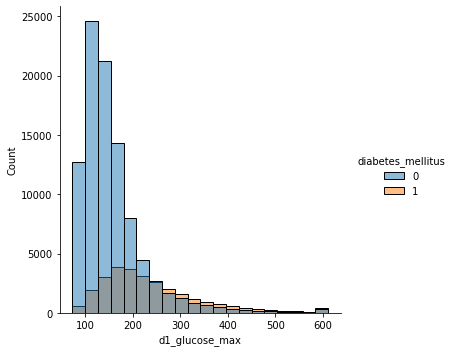

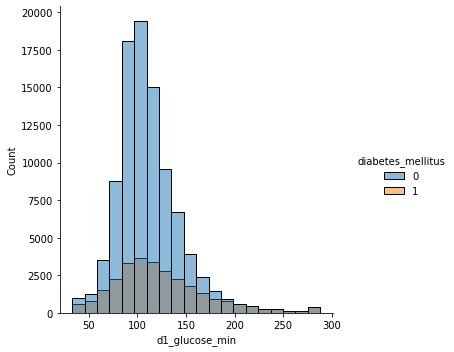

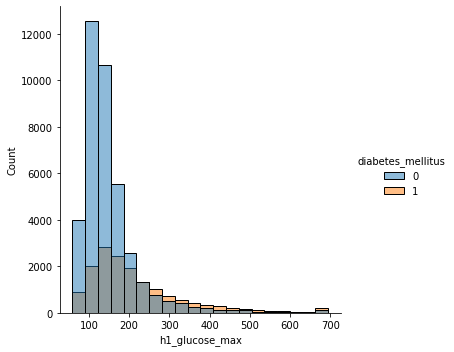

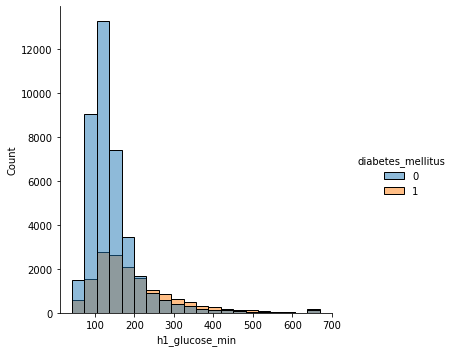

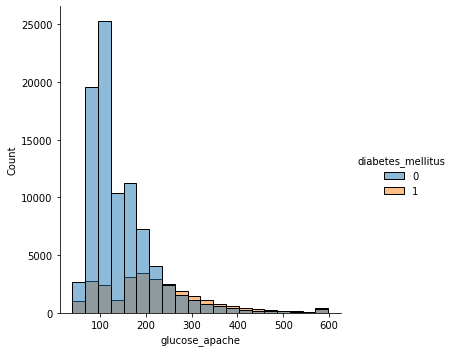

In [ ]:
#fig, ax = plt.subplots(figsize=(20, 10))
#fig, axes = plt.subplots(3,3)
sns.displot(data=df,x="d1_glucose_max",hue=TARGET_COL,bins=20,aspect=1)   
sns.displot(data=df, x="d1_glucose_min",hue=TARGET_COL,bins=20,aspect=1)    
sns.displot(data=df, x="h1_glucose_max",hue=TARGET_COL,bins=20,aspect=1)    
sns.displot(data=df, x="h1_glucose_min",hue=TARGET_COL,bins=20,aspect=1) 
sns.displot(data=df, x="glucose_apache",hue=TARGET_COL,bins=20,aspect=1) 

In [ ]:
print(df[df["d1_glucose_max"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["d1_glucose_min"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["h1_glucose_max"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["h1_glucose_min"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["glucose_apache"].isnull()].groupby(TARGET_COL)["encounter_id"].count())

diabetes_mellitus
0    7710
1     533
Name: encounter_id, dtype: int64
diabetes_mellitus
0    7710
1     533
Name: encounter_id, dtype: int64
diabetes_mellitus
0    62600
1    12473
Name: encounter_id, dtype: int64
diabetes_mellitus
0    62600
1    12473
Name: encounter_id, dtype: int64
diabetes_mellitus
0    13654
1     1042
Name: encounter_id, dtype: int64


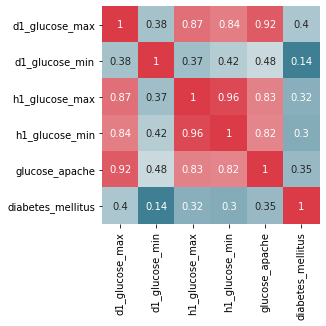

In [ ]:
glucose_cols=["d1_glucose_max","d1_glucose_min","h1_glucose_max","h1_glucose_min","glucose_apache",TARGET_COL]
corr_glucose=df[glucose_cols].corr()
sns.heatmap(corr_glucose, mask=np.zeros_like(corr_glucose, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, cbar=False,annot=True)

In [ ]:
df[glucose_cols].describe()

,d1_glucose_max,d1_glucose_min,h1_glucose_max,h1_glucose_min,glucose_apache,diabetes_mellitus
count,121914.000000,121914.000000,55084.000000,55084.000000,115461.000000,130157.000000
mean,174.149802,114.440310,167.702625,158.908794,160.141416,0.216285
std,86.545466,38.217682,94.033461,88.298827,90.701327,0.411712
min,73.000000,33.000000,59.000000,42.000000,39.000000,0.000000
25%,117.000000,91.000000,111.000000,106.000000,97.000000,0.000000
50%,150.000000,108.000000,140.000000,134.000000,133.000000,0.000000
75%,200.000000,131.000000,189.000000,179.000000,195.000000,0.000000
max,611.000000,288.000000,695.045000,670.000000,598.700000,1.000000


In [ ]:
features_models=["d1_glucose_max","d1_glucose_min","h1_glucose_max","h1_glucose_min","glucose_apache"]

# Feature Engineering


In [ ]:
# def _clean_apache_2_diagnosis(x):
#   try:
#     out = str(int(float(x)))
#   except:
#     out = x
#   return out
# df_full['apache_2_diagnosis'] = df_full['apache_2_diagnosis'].apply(_clean_apache_2_diagnosis )

In [ ]:
df_full['gender']=df_full['gender'].str.strip()
df_full['new_gender']=-1
df_full.loc[df_full['gender']=='M','new_gender']=1
df_full.loc[df_full['gender']=='F','new_gender']=0

In [ ]:
df_full = df_full.rename(columns={'pao2_apache':'pao2fio2ratio_apache','ph_apache':'arterial_ph_apache'})

**Process max < min features**

In [ ]:
# lab_col_names =  ['pao2fio2ratio', 'wbc', 'arterial_ph', 'bilirubin',
#   'glucose', 'mbp_noninvasive', 'calcium', 'spo2', 'inr', 'platelets', 'hco3',
#   'creatinine', 'sysbp_invasive', 'mbp_invasive', 'resprate', 'temp', 'sysbp',
#   'sysbp_noninvasive', 'heartrate', 'sodium', 'diasbp_invasive', 'bun', 'arterial_po2',
#   'lactate', 'hematocrit', 'diasbp_noninvasive',
#   'mbp', 'albumin', 'arterial_pco2', 'diasbp', 'hemaglobin', 'potassium']
min_max_feats=[f[:-4] for f in train.columns if f[-4:]=='_min']
first_h = []
for col in min_max_feats:
    df_full.loc[df_full[f'{col}_min'] > df_full[f'{col}_max'], [f'{col}_min', f'{col}_max']] = df_full.loc[df_full[f'{col}_min'] > df_full[f'{col}_max'], [f'{col}_max', f'{col}_min']].values

In [ ]:
df_full['comorbidity_score'] = df_full['aids'].values * 23 + df_full['cirrhosis'] * 4  + df_full['hepatic_failure'] * 16 + df_full['immunosuppression'] * 10 + df_full['leukemia'] * 10 + df_full['lymphoma'] * 13 + df_full['solid_tumor_with_metastasis'] * 11

df_full['comorbidity_score'] = df_full['comorbidity_score'].fillna(0)

df_full['gcs_sum'] = df_full['gcs_eyes_apache']+df_full['gcs_motor_apache']+df_full['gcs_verbal_apache']

df_full['gcs_sum'] = df_full['gcs_sum'].fillna(0)

df_full['apache_2_diagnosis_type'] = df_full.apache_2_diagnosis.round(-1).fillna(-100).astype('int32')

df_full['apache_3j_diagnosis_type'] = df_full.apache_3j_diagnosis.round(-2).fillna(-100).astype('int32')

df_full['bmi_type'] = df_full.bmi.fillna(0).apply(lambda x: 5 * (round(int(x)/5)))

df_full['height_type'] = df_full.height.fillna(0).apply(lambda x: 5 * (round(int(x)/5)))

df_full['weight_type'] = df_full.weight.fillna(0).apply(lambda x: 5 * (round(int(x)/5)))

df_full['age_type'] = df_full.age.fillna(0).apply(lambda x: 10 * (round(int(x)/10)))

df_full['gcs_sum_type'] = df_full.gcs_sum.fillna(0).apply(lambda x: 2.5 * (round(int(x)/2.5))).divide(2.5)

df_full['apache_3j_diagnosis_x'] = df_full['apache_3j_diagnosis'].astype('str').str.split('.',n=1,expand=True)[0]
df_full['apache_2_diagnosis_x'] = df_full['apache_2_diagnosis'].astype('str').str.split('.',n=1,expand=True)[0]

df_full['apache_3j_diagnosis_split1'] = np.where(df_full['apache_3j_diagnosis'].isna() , np.nan , df_full['apache_3j_diagnosis'].astype('str').str.split('.',n=1,expand=True)[1]  )

df_full['apache_2_diagnosis_split1'] = np.where(df_full['apache_2_diagnosis'].isna() , np.nan , df_full['apache_2_diagnosis'].apply(lambda x : x % 10)  )


IDENTIFYING_COLS = ['age_type', 'height_type',  'ethnicity', 'gender', 'bmi_type'] 
df_full['profile'] = df_full[IDENTIFYING_COLS].apply(lambda x: hash(tuple(x)), axis = 1)

print(f'Number of unique Profiles : {df_full["profile"].nunique()}')

Number of unique Profiles : 7184


In [ ]:
df_full_icu = df_full['icu_id']
agg = df_full_icu.value_counts().to_dict()
df_full['icu_id_counts'] = np.log1p(df_full['icu_id'].map(agg))

df_full_age = df_full['age']
agg = df_full_age.value_counts().to_dict()
df_full['age_counts'] = np.log1p(df_full['age'].map(agg))

df_full["diff_bmi"] = df_full['bmi'].copy() 
df_full['bmi'] = df_full['weight']/((df_full['height']/100)**2)
df_full["diff_bmi"] = df_full["diff_bmi"]-df_full['bmi']

df_full['pre_icu_los_days'] = df_full['pre_icu_los_days'].apply(lambda x:special.expit(x) )

df_full['abmi'] = df_full['age']/df_full['bmi']
df_full['agi'] = df_full['weight']/df_full['age']


In [ ]:
d_cols = [c for c in df_full.columns if(c.startswith("d1"))]
h_cols = [c for c in df_full.columns if(c.startswith("h1"))]
df_full["dailyLabs_row_nan_count"] = df_full[d_cols].isna().sum(axis=1)
df_full["hourlyLabs_row_nan_count"] = df_full[h_cols].isna().sum(axis=1)
df_full["diff_labTestsRun_daily_hourly"] = df_full["dailyLabs_row_nan_count"] - df_full["hourlyLabs_row_nan_count"]


In [ ]:
lab_col = [c for c in df_full.columns if((c.startswith("h1")) | (c.startswith("d1")))]
lab_col_names = list(set(list(map(lambda i: i[ 3 : -4], lab_col))))

print("len lab_col",len(lab_col))
print("len lab_col_names",len(lab_col_names))
print("lab_col_names\n",lab_col_names)

len lab_col 128
len lab_col_names 32
lab_col_names
 ['diasbp_invasive', 'sysbp', 'bilirubin', 'wbc', 'mbp_noninvasive', 'calcium', 'resprate', 'spo2', 'glucose', 'hco3', 'temp', 'diasbp_noninvasive', 'mbp', 'diasbp', 'arterial_ph', 'lactate', 'inr', 'arterial_pco2', 'sysbp_invasive', 'heartrate', 'hemaglobin', 'platelets', 'hematocrit', 'sodium', 'arterial_po2', 'albumin', 'mbp_invasive', 'sysbp_noninvasive', 'creatinine', 'bun', 'pao2fio2ratio', 'potassium']


In [ ]:
first_h = []
for v in lab_col_names:
    first_h.append(v+"_started_after_firstHour")
    colsx = [x for x in test.columns if v in x]
    df_full[v+"_nans"] = df_full.loc[:, colsx].isna().sum(axis=1)
    test[v+"_nans"] = test.loc[:, colsx].isna().sum(axis=1)
    df_full[v+"_d1_value_range"] = df_full[f"d1_{v}_max"].subtract(df_full[f"d1_{v}_min"])    
    df_full[v+"_h1_value_range"] = df_full[f"h1_{v}_max"].subtract(df_full[f"h1_{v}_min"])
    df_full[v+"_d1_h1_max_eq"] = (df_full[f"d1_{v}_max"]== df_full[f"h1_{v}_max"]).astype(np.int8)
    df_full[v+"_d1_h1_min_eq"] = (df_full[f"d1_{v}_min"]== df_full[f"h1_{v}_min"]).astype(np.int8)
    df_full[v+"_d1_zero_range"] = (df_full[v+"_d1_value_range"] == 0).astype(np.int8)
    df_full[v+"_h1_zero_range"] =(df_full[v+"_h1_value_range"] == 0).astype(np.int8)
    df_full[v+"_tot_change_value_range_normed"] = abs((df_full[v+"_d1_value_range"].div(df_full[v+"_h1_value_range"])))#.div(df[f"d1_{v}_max"]))
    df_full[v+"_started_after_firstHour"] = ((df_full[f"h1_{v}_max"].isna()) & (df_full[f"h1_{v}_min"].isna())) & (~df_full[f"d1_{v}_max"].isna())
    df_full[v+"_day_more_extreme"] = ((df_full[f"d1_{v}_max"]>df_full[f"h1_{v}_max"]) | (df_full[f"d1_{v}_min"]<df_full[f"h1_{v}_min"]))
    df_full[v+"_day_more_extreme"].fillna(False)    
    

df_full["total_Tests_started_After_firstHour"] = df_full[first_h].sum(axis=1)


In [ ]:
groupers = ['apache_3j_diagnosis', 'profile']

for g in groupers:
    for v in lab_col_names:
        temp = df_full[[f"d1_{v}_max",g]].groupby(g)[f"d1_{v}_max"].mean().to_dict()
        df_full[f'mean_diff_d1_{v}_{g}_max'] = df_full[f"d1_{v}_max"]-df_full[g].map(temp)
        temp = df_full[[f"d1_{v}_min",g]].groupby(g)[f"d1_{v}_min"].mean().to_dict()
        df_full[f'mean_diff_d1_{v}_{g}_min'] = df_full[f"d1_{v}_min"]-df_full[g].map(temp)
        temp = df_full[[f"h1_{v}_max",g]].groupby(g)[f"h1_{v}_max"].mean().to_dict()   
        df_full[f'mean_diff_h1_{v}_{g}_max'] = df_full[f"h1_{v}_max"]-df_full[g].map(temp)
        temp = df_full[[f"h1_{v}_min",g]].groupby(g)[f"h1_{v}_min"].mean().to_dict()   
        df_full[f'mean_diff_h1_{v}_{g}_min'] = df_full[f"h1_{v}_min"]-df_full[g].map(temp)
      

In [ ]:
df_full['diasbp_indicator'] = (
(df_full['d1_diasbp_invasive_max'] == df_full['d1_diasbp_max']) & (df_full['d1_diasbp_noninvasive_max']==df_full['d1_diasbp_invasive_max'])|
(df_full['d1_diasbp_invasive_min'] == df_full['d1_diasbp_min']) & (df_full['d1_diasbp_noninvasive_min']==df_full['d1_diasbp_invasive_min'])|
(df_full['h1_diasbp_invasive_max'] == df_full['h1_diasbp_max']) & (df_full['h1_diasbp_noninvasive_max']==df_full['h1_diasbp_invasive_max'])|
(df_full['h1_diasbp_invasive_min'] == df_full['h1_diasbp_min']) & (df_full['h1_diasbp_noninvasive_min']==df_full['h1_diasbp_invasive_min'])
).astype(np.int8)


df_full['mbp_indicator'] = (
(df_full['d1_mbp_invasive_max'] == df_full['d1_mbp_max']) & (df_full['d1_mbp_noninvasive_max']==df_full['d1_mbp_invasive_max'])|
(df_full['d1_mbp_invasive_min'] == df_full['d1_mbp_min']) & (df_full['d1_mbp_noninvasive_min']==df_full['d1_mbp_invasive_min'])|
(df_full['h1_mbp_invasive_max'] == df_full['h1_mbp_max']) & (df_full['h1_mbp_noninvasive_max']==df_full['h1_mbp_invasive_max'])|
(df_full['h1_mbp_invasive_min'] == df_full['h1_mbp_min']) & (df_full['h1_mbp_noninvasive_min']==df_full['h1_mbp_invasive_min'])
).astype(np.int8)

df_full['sysbp_indicator'] = (
(df_full['d1_sysbp_invasive_max'] == df_full['d1_sysbp_max']) & (df_full['d1_sysbp_noninvasive_max']==df_full['d1_sysbp_invasive_max'])|
(df_full['d1_sysbp_invasive_min'] == df_full['d1_sysbp_min']) & (df_full['d1_sysbp_noninvasive_min']==df_full['d1_sysbp_invasive_min'])|
 (df_full['h1_sysbp_invasive_max'] == df_full['h1_sysbp_max']) & (df_full['h1_sysbp_noninvasive_max']==df_full['h1_sysbp_invasive_max'])|
(df_full['h1_sysbp_invasive_min'] == df_full['h1_sysbp_min']) & (df_full['h1_sysbp_noninvasive_min']==df_full['h1_sysbp_invasive_min'])   
).astype(np.int8)

df_full['d1_mbp_invnoninv_max_diff'] = df_full['d1_mbp_invasive_max'] - df_full['d1_mbp_noninvasive_max']
df_full['h1_mbp_invnoninv_max_diff'] = df_full['h1_mbp_invasive_max'] - df_full['h1_mbp_noninvasive_max']
df_full['d1_mbp_invnoninv_min_diff'] = df_full['d1_mbp_invasive_min'] - df_full['d1_mbp_noninvasive_min']
df_full['h1_mbp_invnoninv_min_diff'] = df_full['h1_mbp_invasive_min'] - df_full['h1_mbp_noninvasive_min']
df_full['d1_diasbp_invnoninv_max_diff'] = df_full['d1_diasbp_invasive_max'] - df_full['d1_diasbp_noninvasive_max']
df_full['h1_diasbp_invnoninv_max_diff'] = df_full['h1_diasbp_invasive_max'] - df_full['h1_diasbp_noninvasive_max']
df_full['d1_diasbp_invnoninv_min_diff'] = df_full['d1_diasbp_invasive_min'] - df_full['d1_diasbp_noninvasive_min']
df_full['h1_diasbp_invnoninv_min_diff'] = df_full['h1_diasbp_invasive_min'] - df_full['h1_diasbp_noninvasive_min']
df_full['d1_sysbp_invnoninv_max_diff'] = df_full['d1_sysbp_invasive_max'] - df_full['d1_sysbp_noninvasive_max']
df_full['h1_sysbp_invnoninv_max_diff'] = df_full['h1_sysbp_invasive_max'] - df_full['h1_sysbp_noninvasive_max']
df_full['d1_sysbp_invnoninv_min_diff'] = df_full['d1_sysbp_invasive_min'] - df_full['d1_sysbp_noninvasive_min']
df_full['h1_sysbp_invnoninv_min_diff'] = df_full['h1_sysbp_invasive_min'] - df_full['h1_sysbp_noninvasive_min']

In [ ]:
for v in ['albumin','bilirubin','bun','glucose','hematocrit','pao2fio2ratio','arterial_ph','resprate','sodium','temp','wbc','creatinine']:
    df_full[f'{v}_indicator'] = (((df_full[f'{v}_apache']==df_full[f'd1_{v}_max']) & (df_full[f'd1_{v}_max']==df_full[f'h1_{v}_max'])) |
                 ((df_full[f'{v}_apache']==df_full[f'd1_{v}_max']) & (df_full[f'd1_{v}_max']==df_full[f'd1_{v}_min'])) |
                 ((df_full[f'{v}_apache']==df_full[f'd1_{v}_max']) & (df_full[f'd1_{v}_max']==df_full[f'h1_{v}_min'])) |
                 ((df_full[f'{v}_apache']==df_full[f'h1_{v}_max']) & (df_full[f'h1_{v}_max']==df_full[f'd1_{v}_max'])) |
                 ((df_full[f'{v}_apache']==df_full[f'h1_{v}_max']) & (df_full[f'h1_{v}_max']==df_full[f'h1_{v}_min'])) |
                 ((df_full[f'{v}_apache']==df_full[f'h1_{v}_max']) & (df_full[f'h1_{v}_max']==df_full[f'd1_{v}_min'])) |
                 ((df_full[f'{v}_apache']==df_full[f'd1_{v}_min']) & (df_full[f'd1_{v}_min']==df_full[f'd1_{v}_max'])) |
                 ((df_full[f'{v}_apache']==df_full[f'd1_{v}_min']) & (df_full[f'd1_{v}_min']==df_full[f'h1_{v}_min'])) |
                 ((df_full[f'{v}_apache']==df_full[f'd1_{v}_min']) & (df_full[f'd1_{v}_min']==df_full[f'h1_{v}_max'])) |
                 ((df_full[f'{v}_apache']==df_full[f'h1_{v}_min']) & (df_full[f'h1_{v}_min']==df_full[f'h1_{v}_max'])) |
                 ((df_full[f'{v}_apache']==df_full[f'h1_{v}_min']) & (df_full[f'h1_{v}_min']==df_full[f'd1_{v}_min'])) |
                 ((df_full[f'{v}_apache']==df_full[f'h1_{v}_min']) & (df_full[f'h1_{v}_min']==df_full[f'd1_{v}_max'])) 
                ).astype(np.int8)

In [ ]:
more_extreme_cols = [c for c in df_full.columns if(c.endswith("_day_more_extreme"))]
df_full["total_day_more_extreme"] = df_full[more_extreme_cols].sum(axis=1)

df_full["d1_resprate_div_mbp_min"] = df_full["d1_resprate_min"].div(df_full["d1_mbp_min"])
df_full["d1_resprate_div_sysbp_min"] = df_full["d1_resprate_min"].div(df_full["d1_sysbp_min"])
df_full["d1_lactate_min_div_diasbp_min"] = df_full["d1_lactate_min"].div(df_full["d1_diasbp_min"])
df_full["d1_heartrate_min_div_d1_sysbp_min"] = df_full["d1_heartrate_min"].div(df_full["d1_sysbp_min"])
df_full["d1_hco3_div"]= df_full["d1_hco3_max"].div(df_full["d1_hco3_min"])
df_full["d1_resprate_times_resprate"] = df_full["d1_resprate_min"].multiply(df_full["d1_resprate_max"])
df_full["left_average_spo2"] = (2*df_full["d1_spo2_max"] + df_full["d1_spo2_min"])/3

df_full["total_chronic"] = df_full[["aids","cirrhosis", 'hepatic_failure']].sum(axis=1)
df_full["total_cancer_immuno"] = df_full[[ 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].sum(axis=1)

df_full["has_complicator"] = df_full[["aids","cirrhosis", 'hepatic_failure',
                            'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].max(axis=1)

In [ ]:
df_full['apache_3j'] = np.where(df_full['apache_3j_diagnosis_type']<0 , np.nan ,
                            np.where(df_full['apache_3j_diagnosis_type'] < 200, 'Cardiovascular' , 
                            np.where(df_full['apache_3j_diagnosis_type'] < 400, 'Respiratory' , 
                            np.where(df_full['apache_3j_diagnosis_type'] < 500, 'Neurological' , 
                            np.where(df_full['apache_3j_diagnosis_type'] < 600, 'Sepsis' , 
                            np.where(df_full['apache_3j_diagnosis_type'] < 800, 'Trauma' ,  
                            np.where(df_full['apache_3j_diagnosis_type'] < 900, 'Haematological' ,         
                            np.where(df_full['apache_3j_diagnosis_type'] < 1000, 'Renal/Genitourinary' ,         
                            np.where(df_full['apache_3j_diagnosis_type'] < 1200, 'Musculoskeletal/Skin disease' , 'Operative Sub-Diagnosis Codes' )))))))))

In [ ]:
cats = ['elective_surgery', 'icu_id', 'arf_apache', 'intubated_apache', 'ventilated_apache', 'cirrhosis','hepatic_failure', 'immunosuppression', 'leukemia', 'solid_tumor_with_metastasis', 'apache_3j_diagnosis_x','apache_2_diagnosis_x', 'apache_3j', 'apache_3j_diagnosis_split1', 'apache_2_diagnosis_split1', 'gcs_sum_type','hospital_admit_source', 'gcs_eyes_apache','total_cancer_immuno','gender', 'total_chronic', 'icu_stay_type', 'apache_2_diagnosis_type', 'apache_3j_diagnosis_type']

In [ ]:
t_train=df_full[df_full[TARGET_COL].notnull()]
t_test=df_full[df_full[TARGET_COL].isnull()]
for col in cats:
    t_train_only = list(set(t_train[col].unique()) - set(t_test[col].unique()))
    t_test_only = list(set(t_test[col].unique()) - set(t_train[col].unique()))
    both = list(set(t_test[col].unique()).union(set(t_train[col].unique())))
    t_train.loc[t_train[col].isin(t_train_only), col] = np.nan
    t_test.loc[t_test[col].isin(t_test_only), col] = np.nan
    try:
        lbl = OrdinalEncoder(dtype='int')
        t_train[col] = lbl.fit_transform(t_train[col].astype('str').values.reshape(-1,1))
        t_test[col] = lbl.transform(t_test[col].astype('str').values.reshape(-1,1))
    except:
        lbl = OrdinalEncoder(dtype='int')
        t_train[col] = lbl.fit_transform(t_train[col].astype('str').fillna('-1').values.reshape(-1,1))
        t_test[col] = lbl.transform(t_test[col].astype('str').fillna('-1').values.reshape(-1,1))
    temp = pd.concat([t_train[[col]], t_test[[col]]], axis=0)
    temp_mapping = temp.groupby(col).size()/len(temp)
    temp['enc'] = temp[col].map(temp_mapping)
    temp['enc'] = stats.rankdata(temp['enc'])
    temp = temp.reset_index(drop=True)
    t_train[f'rank_frqenc_{col}'] = temp[['enc']].values[:t_train.shape[0]]
    t_test[f'rank_frqenc_{col}'] = temp[['enc']].values[t_train.shape[0]:]  
    col1=f'rank_frqenc_{col}'
    df_full[f'rank_frqenc_{col}']= pd.concat([t_train[[col1]], t_test[[col1]]], axis=0)   
    df_full[col]= pd.concat([t_train[[col]], t_test[[col]]], axis=0)           
    # t_test[col] = t_test[col].astype('category')
    # t_train[col] = t_train[col].astype('category')
    # df_full[col]=df_full[col].astype('category')

In [ ]:
drop_cols = ['abmi', 'age_type', 'aids', 'albumin_apache', 'albumin_h1_value_range', 'albumin_h1_zero_range','albumin_tot_change_value_range_normed', 'apache_3j_diagnosis-cat_age', 'apache_post_operative','apache_post_operative_std_d1_temp_max', 'arf_apache_std_d1_hemaglobin_max', 'arterial_pco2_d1_h1_max_eq','arterial_pco2_d1_h1_min_eq', 'arterial_pco2_d1_zero_range', 'arterial_pco2_h1_zero_range','arterial_ph_apache', 'arterial_ph_d1_h1_max_eq', 'arterial_ph_d1_value_range', 'arterial_ph_d1_zero_range','arterial_ph_h1_zero_range', 'arterial_po2_d1_h1_max_eq', 'arterial_po2_d1_h1_min_eq', 'arterial_po2_d1_value_range', 'bilirubin_h1_value_range', 'bilirubin_h1_zero_range','bilirubin_tot_change_value_range_normed', 'bmi_type', 'bun_d1_h1_max_eq', 'bun_d1_zero_range','bun_h1_value_range', 'bun_h1_zero_range', 'calcium_d1_zero_range', 'calcium_h1_value_range','calcium_h1_zero_range', 'creatinine_h1_zero_range', 'd1_albumin_min', 'd1_arterial_pco2_min','d1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_calcium_max', 'd1_diasbp_max', 'd1_diasbp_min','d1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max','d1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'd1_platelets_max', 'd1_resprate_max', 'd1_sysbp_invasive_min', 'd1_temp_min','d1_wbc_min', 'diasbp_d1_h1_max_eq', 'diasbp_d1_zero_range', 'diasbp_invasive_d1_h1_max_eq','diasbp_invasive_d1_value_range', 'diasbp_invasive_d1_zero_range', 'diasbp_invasive_h1_value_range','diasbp_invasive_h1_zero_range', 'diasbp_noninvasive_d1_h1_max_eq', 'diasbp_noninvasive_d1_zero_range','diasbp_noninvasive_h1_zero_range', 'diff_bmi', 'elective_surgery_mean_d1_sysbp_min', 'gcs_unable_apache','h1_albumin_max', 'h1_albumin_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_ph_min','h1_arterial_po2_max', 'h1_bilirubin_max', 'h1_bun_max', 'h1_creatinine_min', 'h1_diasbp_noninvasive_max','h1_heartrate_max', 'h1_heartrate_min', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min','h1_lactate_max', 'h1_lactate_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min','h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min','h1_platelets_max', 'h1_platelets_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_sodium_max','h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max','h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'h1_wbc_max', 'h1_wbc_min', 'hco3_d1_h1_max_eq','hco3_d1_h1_min_eq', 'hco3_h1_value_range', 'hco3_h1_zero_range', 'heartrate_d1_zero_range','heartrate_h1_zero_range', 'height', 'hemaglobin_d1_value_range', 'hemaglobin_d1_zero_range','hematocrit_apache', 'hematocrit_d1_h1_min_eq', 'hematocrit_d1_value_range', 'hematocrit_d1_zero_range','inr_d1_h1_max_eq', 'inr_d1_h1_min_eq', 'inr_d1_value_range', 'inr_d1_zero_range', 'inr_day_more_extreme','inr_h1_value_range', 'inr_h1_zero_range', 'inr_started_after_firstHour', 'intubated_apache_mean_d1_spo2_max','lactate_h1_value_range', 'lactate_h1_zero_range', 'lymphoma', 'map_apache', 'mbp_d1_zero_range','mbp_h1_zero_range', 'mbp_invasive_d1_h1_min_eq', 'mbp_invasive_d1_value_range', 'mbp_invasive_d1_zero_range','mbp_invasive_h1_zero_range', 'mbp_noninvasive_d1_h1_max_eq', 'mbp_noninvasive_d1_h1_min_eq','mbp_noninvasive_d1_zero_range', 'mbp_noninvasive_h1_zero_range', 'mean_diff_d1_inr_min','mean_diff_h1_bilirubin_min', 'mean_diff_h1_inr_max', 'paco2_apache', 'paco2_for_ph_apache','pao2fio2ratio_apache', 'pao2fio2ratio_h1_value_range', 'pao2fio2ratio_h1_zero_range','rank_frqenc_leukemia', 'wbc_h1_value_range','platelets_d1_value_range', 'platelets_h1_zero_range', 'potassium_d1_h1_max_eq','potassium_h1_value_range','potassium_h1_zero_range', 'rank_frqenc_apache_2_diagnosis', 'resprate_apache', 'resprate_d1_h1_min_eq','resprate_d1_zero_range', 'sodium_d1_h1_min_eq', 'sodium_d1_zero_range','spo2_d1_h1_max_eq','sysbp_d1_zero_range', 'sysbp_h1_zero_range', 'sysbp_invasive_d1_h1_min_eq','sysbp_invasive_d1_zero_range','sysbp_noninvasive_d1_h1_min_eq', 'sysbp_noninvasive_d1_zero_range','sysbp_noninvasive_h1_zero_range','temp_d1_zero_range', 'ventilated_apache_std_d1_glucose_min', 'wbc_apache', 'wbc_d1_h1_min_eq','wbc_d1_value_range', 'wbc_d1_zero_range', 'wbc_h1_zero_range', 'gcs_eyes_apache_mean_d1_bun_min','rank_frqenc_aids']

In [ ]:
# drop_cols = list(set(drop_cols))
# print(len(drop_cols))
# df_full = df_full.drop(drop_cols, axis=1)


**Process invasive/non invasive columns**




In [ ]:
invasive_cols = [col for col in df.columns if (('invasive' in col))]
invasive_cols

ivasive_label=['diasbp','mbp','sysbp']
df_full['sum_na_invasive']=0
for col in ivasive_label:
     d1_invasive_max = "d1_"+col+"_invasive_max"
     d1_invasive_min = "d1_"+col+"_invasive_min"
     h1_invasive_max = "h1_"+col+"_invasive_max"
     h1_invasive_min = "h1_"+col+"_invasive_min"
     d1_noninvasive_max = "d1_"+col+"_noninvasive_max"
     d1_noninvasive_min = "d1_"+col+"_noninvasive_min"
     h1_noninvasive_max = "h1_"+col+"_noninvasive_max"
     h1_noninvasive_min = "h1_"+col+"_noninvasive_min"
     df_full[col+"_sum_na_invasive"]=df_full[[d1_invasive_max,d1_invasive_min,h1_invasive_max,h1_invasive_min]].isna().sum(axis=1)
     df_full[col+"_sum_na_noninvasive"]=df_full[[d1_noninvasive_max,d1_noninvasive_min,h1_noninvasive_max,h1_noninvasive_min]].isna().sum(axis=1)
     df_full[col+"_sum_na_full_invasive"]= df_full[col+"_sum_na_invasive"]+df_full[col+"_sum_na_noninvasive"]
     df_full['sum_na_invasive']=df_full['sum_na_invasive']+df_full[col+"_sum_na_invasive"]
     df_full[col+"std_invasive"]=df_full[[d1_invasive_max,d1_invasive_min,h1_invasive_max,h1_invasive_min,
                                          d1_noninvasive_max,d1_noninvasive_min,h1_noninvasive_max,h1_noninvasive_min]].std(axis=1)
     df_full[col+"max_invasive"]=df_full[[d1_invasive_max,d1_invasive_min,h1_invasive_max,h1_invasive_min,
                                          d1_noninvasive_max,d1_noninvasive_min,h1_noninvasive_max,h1_noninvasive_min]].max(axis=1)
     df_full[col+"min_invasive"]=df_full[[d1_invasive_max,d1_invasive_min,h1_invasive_max,h1_invasive_min,
                                          d1_noninvasive_max,d1_noninvasive_min,h1_noninvasive_max,h1_noninvasive_min]].min(axis=1)
     df_full[col+"mean_invasive"]=df_full[[d1_invasive_max,d1_invasive_min,h1_invasive_max,h1_invasive_min,
                                          d1_noninvasive_max,d1_noninvasive_min,h1_noninvasive_max,h1_noninvasive_min]].mean(axis=1)
     df_full[col+"mean_invasive_h"]=df_full[[h1_invasive_max,h1_invasive_min,
                                          h1_noninvasive_max,h1_noninvasive_min]].mean(axis=1)
     df_full[col+"mean_invasive_d"]=df_full[[d1_invasive_max,d1_invasive_min,
                                          d1_noninvasive_max,d1_noninvasive_min]].mean(axis=1)
     df_full[col+"max_min_invasive"]=df_full[col+"max_invasive"]-df_full[col+"min_invasive"]
     df_full[col+'_d1_max_in_vs_non_vasive']=df_full[d1_invasive_max]-df_full[d1_noninvasive_max]
     df_full[col+'_h1_max_in_vs_non_vasive']=df_full[h1_invasive_max]-df_full[h1_noninvasive_max]
     df_full[col+'_d1_min_in_vs_non_vasive']=df_full[d1_invasive_min]-df_full[d1_noninvasive_min]
     df_full[col+'_h1_min_in_vs_non_vasive']=df_full[h1_invasive_min]-df_full[h1_noninvasive_min]

**Process difference between readings of patients**

In [ ]:
d_cols = [c for c in df_full.columns if(c.startswith("d1"))]
h_cols = [c for c in df_full.columns if(c.startswith("h1"))]

df_full["dailyLabs_row_nan_count"] = df_full[d_cols].isna().sum(axis=1)
df_full["hourlyLabs_row_nan_count"] = df_full[h_cols].isna().sum(axis=1)

df_full["diff_labTestsRun_daily_hourly"] = df_full["dailyLabs_row_nan_count"] - df_full["hourlyLabs_row_nan_count"]

features_models.append('dailyLabs_row_nan_count')
features_models.append('hourlyLabs_row_nan_count')
features_models.append('diff_labTestsRun_daily_hourly')
#tiếp tục refer top 1 notebook để tạo thêm feature

In [ ]:
lab_col_names =  ['pao2fio2ratio', 'wbc', 'arterial_ph', 'bilirubin',
  'glucose', 'mbp_noninvasive', 'calcium', 'spo2', 'inr', 'platelets', 'hco3',
  'creatinine', 'sysbp_invasive', 'mbp_invasive', 'resprate', 'temp', 'sysbp',
  'sysbp_noninvasive', 'heartrate', 'sodium', 'diasbp_invasive', 'bun', 'arterial_po2',
  'lactate', 'hematocrit', 'diasbp_noninvasive',
  'mbp', 'albumin', 'arterial_pco2', 'diasbp', 'hemaglobin', 'potassium']
first_h = []
# df_1=df[df[TARGET_COL]==1]
# df_0=df[df[TARGET_COL]==0]
for v in lab_col_names:
    h1_idx_min='h1_'+v+'_min'
    h1_idx_max='h1_'+v+'_max'
    d1_idx_min='d1_'+v+'_min'
    d1_idx_max='d1_'+v+'_max'
    # mean_h1_min_1=df_1[h1_idx_min].mean()
    # mean_d1_min_1=df_1[d1_idx_min].mean()
    # mean_h1_max_1=df_1[h1_idx_max].mean()
    # mean_d1_max_1=df_1[d1_idx_max].mean()
    # mean_h1_min_0=df_0[h1_idx_min].mean()
    # mean_d1_min_0=df_0[d1_idx_min].mean()
    # mean_h1_max_0=df_0[h1_idx_max].mean()
    # mean_d1_max_0=df_0[d1_idx_max].mean()
    dis_h1_min_0= 'h1_min_'+v+'_dis_0'
    dis_d1_min_0= 'd1_min_'+v+'_dis_0'
    dis_h1_min_1= 'h1_min_'+v+'_dis_1'
    dis_d1_min_1= 'd1_min_'+v+'_dis_1'
    dis_h1_max_0= 'h1_max_'+v+'_dis_0'
    dis_d1_max_0= 'd1_max_'+v+'_dis_0'
    dis_h1_max_1= 'h1_max_'+v+'_dis_1'
    dis_d1_max_1= 'd1_max_'+v+'_dis_1'
    # df_full[dis_h1_min_0]=df_full[h1_idx_min]-mean_h1_min_0
    # df_full[dis_d1_min_0]=df_full[d1_idx_min]-mean_d1_min_0
    # df_full[dis_h1_min_1]=df_full[h1_idx_min]-mean_h1_min_1
    # df_full[dis_d1_min_1]=df_full[d1_idx_min]-mean_d1_min_1
    # df_full[dis_h1_max_0]=df_full[h1_idx_max]-mean_h1_max_0
    # df_full[dis_d1_max_0]=df_full[d1_idx_max]-mean_d1_max_0
    # df_full[dis_h1_max_1]=df_full[h1_idx_max]-mean_h1_max_1
    # df_full[dis_d1_max_1]=df_full[d1_idx_max]-mean_d1_max_1
    df_full[v+"_d1_value_range"] = df_full[f"d1_{v}_max"].subtract(df_full[f"d1_{v}_min"])
    df_full[v+"_dh_max_value_range"] = df_full[f"d1_{v}_max"].subtract(df_full[f"h1_{v}_max"])
    df_full[v+"_dh_min_value_range"] = df_full[f"d1_{v}_min"].subtract(df_full[f"h1_{v}_min"])
    df_full[v+"_dh_maxmin_value_range"] = df_full[f"d1_{v}_max"].subtract(df_full[f"h1_{v}_min"])
    features_models.append(v+"_d1_value_range")
    df_full[v+"_h1_value_range"] = df_full[f"h1_{v}_max"].subtract(df_full[f"h1_{v}_min"])
#     df_full[v+"_h1_value_range_normalized"] = df_full[f"h1_{v}_max"].subtract(df_full[f"h1_{v}_min"]).div(df_full[f"h1_{v}_max"])
    features_models.append(v+"_h1_value_range")
    # daily change in value range - hour vs day. could do subtract or div here.. 
    df_full[v+"_tot_change_value_range_normed"] = abs((df_full[v+"_d1_value_range"].div(df_full[v+"_h1_value_range"])))#.div(df_full[f"d1_{v}_max"]))
    features_models.append(v+"_tot_change_value_range_normed")
    # Cases where there's no reading in the first hour, but only  later in day ?
    df_full[v+"_started_after_firstHour"] = ((df_full[f"h1_{v}_max"].isna()) & (df_full[f"h1_{v}_min"].isna())) & (~df_full[f"d1_{v}_max"].isna())
    features_models.append(v+"_started_after_firstHour")
    first_h.append(v+"_started_after_firstHour")
    list_cols=[f"d1_{v}_max",f"d1_{v}_min",f"h1_{v}_max",f"h1_{v}_min"]
    df_full[v+"_std"]=df_full[list_cols].std(axis=1)
    df_full[v+"_max"]=df_full[list_cols].max(axis=1)
    df_full[v+"_min"]=df_full[list_cols].min(axis=1)
    df_full[v+"_mean"]=df_full[list_cols].mean(axis=1)
    df_full[v+"_mean_h"]=df_full[[h1_idx_min,h1_idx_max]].mean(axis=1)
    df_full[v+"_mean_d"]=df_full[[d1_idx_min,d1_idx_max]].mean(axis=1)
    df_full[v+"_max_min"]=df_full[v+"_max"]-df_full[v+"_min"]


    ## Did a reading get more extreme after the first hour. 
    ## This misses cases where the readying is in an unhealthy region and "improves"!!
    df_full[v+"_day_more_extreme"] = ((df_full[f"d1_{v}_max"]>df_full[f"h1_{v}_max"]) | (df_full[f"d1_{v}_min"]<df_full[f"h1_{v}_min"]))
    df_full[v+"_day_more_extreme"].fillna(False)

df_full["total_Tests_started_After_firstHour"] = df_full[first_h].sum(axis=1)
more_extreme_cols = [c for c in df_full.columns if(c.endswith("_day_more_extreme"))]

df_full["total_day_more_extreme"] = df_full[more_extreme_cols].sum(axis=1)


In [ ]:
df_full['NA_info']=df_full[df_full.columns].isna().sum(axis=1)
features_models.append('NA_info')

**Process "glucose" feats**

In [ ]:
glu_map = {}
for n in range(0,10):
    start=n*30
    end=(n+1)*30
    count=df.loc[((df["d1_glucose_max"]>start)& (df["d1_glucose_max"]<=end)),"d1_glucose_max"].count()
    count_1=df.loc[((df["d1_glucose_max"]>start) & (df["d1_glucose_max"]<=end) & (df[TARGET_COL]==1)),"d1_glucose_max"].count()
    glu_map[n]=(count_1/count)
glu_map[10]=(df.loc[((df["d1_glucose_max"]>300)),"d1_glucose_max"].count())/(df.loc[((df["d1_glucose_max"]>300) & (df[TARGET_COL]==1)),"d1_glucose_max"].count())
glu_map[0]=0
glu_map[0]=0

In [ ]:
glu_map

{0: 0,
 1: nan,
 2: 0.04770375161707632,
 3: 0.05922098569157393,
 4: 0.11576867816091954,
 5: 0.20434401480471412,
 6: 0.319634703196347,
 7: 0.42674595141700405,
 8: 0.5137128806506526,
 9: 0.5549933422103861,
 10: 1.663129973474801}

In [ ]:
def glucose_prob(x):
    if pd.isna(x):
        return np.nan
    n=x//50
    if n > 10:
        n=10
    return glu_map[n]

In [ ]:
def glucoseclasst(x):
    if pd.isna(x):
        return np.nan
    if x < 100: return 0 
    elif x >= 100 and x < 120: return 1
    elif x >=120 and x < 140: return 2 
    elif x >= 140 and x < 200: return 3 
    elif x >= 200 and x < 300: return 4 
    elif x >= 300: return 5 

In [ ]:
 #count number of glucose NA
glucose_d=["d1_glucose_max","d1_glucose_min"]
glucose_h=["h1_glucose_max","h1_glucose_min"]
glucose_columns = ["d1_glucose_max","d1_glucose_min","h1_glucose_max","h1_glucose_min"]
df_full["glucose_na_h"] = df_full[glucose_h].isna().sum(axis=1)
df_full["glucose_na_d"] = df_full[glucose_d].isna().sum(axis=1)
df_full["glucose_na"] = df_full["glucose_na_h"] + df_full["glucose_na_d"]

features_models =features_models + ["glucose_na_h","glucose_na_d","glucose_na"]

 #fillNA
df_full.loc[df_full["d1_glucose_max"].isna() & (df_full["glucose_apache"].notna()),"d1_glucose_max"]=df_full.loc[df_full["d1_glucose_max"].isna() & (df_full["glucose_apache"].notna()),"glucose_apache"]
# df_full['d1_glucose_max']=df_full['d1_glucose_max'].fillna(0)
# df_full['d1_glucose_min']=df_full['d1_glucose_min'].fillna(0)
df_full.loc[df_full["h1_glucose_min"].isna() & (df_full["d1_glucose_min"].notna()),"h1_glucose_min"]=df_full.loc[df_full["h1_glucose_min"].isna() & (df_full["d1_glucose_min"].notna()),"d1_glucose_min"]
df_full.loc[df_full["h1_glucose_max"].isna() & (df_full["d1_glucose_max"].notna()),"h1_glucose_min"]=df_full.loc[df_full["h1_glucose_max"].isna() & (df_full["d1_glucose_max"].notna()),"d1_glucose_max"]
# df_full['h1_glucose_min']=df_full['h1_glucose_min'].fillna(0)
# df_full['h1_glucose_max']=df_full['h1_glucose_max'].fillna(0)

# Create new feature
df_full['glucose_max_min_d']= df_full['d1_glucose_max']-df_full['d1_glucose_min']
df_full['glucose_max_min_h']= df_full['h1_glucose_max']-df_full['h1_glucose_min']
df_full['glucose_d_h'] = df_full['d1_glucose_max']-df_full['h1_glucose_max']

df_full['d_max_glucose_risk_200']=0
df_full.loc[df_full["d1_glucose_max"]>=200,"d_max_glucose_risk_200"]=1
df_full['d_max_glucose_risk_140']=0
df_full.loc[df_full["d1_glucose_max"]>=140,"d_max_glucose_risk_140"]=1

df_full['d_min_glucose_risk_200']=0
df_full.loc[df_full["d1_glucose_min"]>=200,"d_min_glucose_risk_200"]=1
df_full['d_min_glucose_risk_140']=0
df_full.loc[df_full["d1_glucose_min"]>=140,"d_min_glucose_risk_140"]=1


df_full['h_max_glucose_risk_200']=0
df_full.loc[df_full["h1_glucose_max"]>=200,"h_max_glucose_risk_200"]=1
df_full['h_max_glucose_risk_140']=0
df_full.loc[df_full["h1_glucose_max"]>=140,"h_max_glucose_risk_140"]=1

df_full['h_min_glucose_risk_200']=0
df_full.loc[df_full["h1_glucose_min"]>=200,"h_min_glucose_risk_200"]=1
df_full['h_min_glucose_risk_140']=0
df_full.loc[df_full["h1_glucose_min"]>=140,"h_min_glucose_risk_140"]=1

df_full['glu_risk_200']= df_full['d_max_glucose_risk_200'] + df_full['d_min_glucose_risk_200'] + df_full['h_max_glucose_risk_200'] + df_full['h_min_glucose_risk_200']

df_full['glu_risk_140']= df_full['d_max_glucose_risk_140'] + df_full['d_min_glucose_risk_140'] + df_full['h_max_glucose_risk_140'] + df_full['h_min_glucose_risk_140']


mean_glucose_1=df.loc[df[TARGET_COL]==1,'d1_glucose_max'].mean()
mean_glucose_0=df.loc[df[TARGET_COL]==0,'d1_glucose_max'].mean()

std_glucose_1=df.loc[df[TARGET_COL]==1,'d1_glucose_max'].std()
std_glucose_0=df.loc[df[TARGET_COL]==0,'d1_glucose_max'].std()
df_full['glucose_max_mean_1']=df_full['d1_glucose_max']-mean_glucose_1
df_full['glucose_max_mean_0']=df_full['d1_glucose_max']-mean_glucose_0

df_full['glucose_max_std_1']=(df_full['d1_glucose_max']-mean_glucose_1)/std_glucose_1
df_full['glucose_max_std_0']=(df_full['d1_glucose_max']-mean_glucose_1)/std_glucose_0

df_full['glucose_prob']=df_full['d1_glucose_max'].map(glucose_prob)

df_full['glucose_std']= df_full[glucose_columns].std(axis=1)

df_full['d_max_glu_class'] = df_full['d1_glucose_max'].map(glucoseclasst)
df_full['d_min_glu_class'] = df_full['d1_glucose_min'].map(glucoseclasst)
df_full['h_max_glu_class'] = df_full['h1_glucose_max'].map(glucoseclasst)
df_full['h_min_glu_class'] = df_full['h1_glucose_min'].map(glucoseclasst)
df_full['glu_sum_class_d'] = df_full['d_max_glu_class'] +df_full['d_min_glu_class']
df_full['glu_sum_class_h'] = df_full['h_max_glu_class'] +df_full['h_min_glu_class']

df_full['glu_sum_class']=df_full['glu_sum_class_d']+df_full['glu_sum_class_h']

features_models=features_models+["glucose_max_min_d","glucose_max_min_h","glucose_d_h","glucose_risk_200","glucose_risk_140"
                                  ,'glucose_max_mean_1','glucose_max_mean_0','glucose_max_std_1','glucose_max_std_0','glucose_prob']
features_models.append("glucose_std")


**Process AGE,BMI,WEIGHT** 

In [ ]:
print(df[df["age"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
df_full["age"].describe()

diabetes_mellitus
0    4328
1     660
Name: encounter_id, dtype: int64


count    135403.000000
mean         62.059991
std          16.904279
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          96.000000
Name: age, dtype: float64

In [ ]:
def weightedclasst(x):
    """based on : https://www.kaggle.com/c/widsdatathon2020/discussion/127987 but made to use ordinals"""
    if pd.isna(x):
        return np.nan
    if x < 15: return 0 
    elif x >= 15 and x < 16: return 1
    elif x >=16 and x < 18.5: return 2 
    elif x >= 18.5 and x < 25: return 3 
    elif x >= 25 and x < 30: return 4 
    elif x >= 30 and x < 35: return 5 
    elif x >= 35: return 6

In [ ]:
df["diff_bmi"] = df['bmi'].copy() # orig BMI values
df['bmi'] = df['weight']/((df['height']/100)**2)
df["diff_bmi"] = df["diff_bmi"]-df['bmi']
df_full['weightclass'] = df_full['bmi'].map(weightedclasst)
# df_full['bmi'].fillna(df_full['bmi'].mean())
# df_full['weightclass'].fillna(1)
print(df_full['weightclass'].value_counts())
features_models.append("weightclass")
features_models.append("bmi")
features_models.append("diff_bmi")

4.0    39940
3.0    39668
5.0    25138
6.0    24482
2.0     4445
1.0      673
0.0      540
Name: weightclass, dtype: int64


In [ ]:
df_full['age'].describe()

count    135403.000000
mean         62.059991
std          16.904279
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          96.000000
Name: age, dtype: float64

In [ ]:
def ageclasst(x):
    if pd.isna(x):
        return np.nan
    if x < 15: return 0 
    elif x >= 15 and x < 25: return 1
    elif x >=25 and x < 35: return 2 
    elif x >= 35 and x < 35: return 3 
    elif x >= 35 and x < 45: return 4 
    elif x >= 45 and x < 55: return 5 
    elif x >= 55 and x < 65: return 6
    elif x >= 65 and x < 75: return 7
    elif x >= 75: return 8

In [ ]:
df_full['ageclass'] = df_full['age'].map(ageclasst)
# df_full['age'].fillna(0)
# df_full['ageclass'].fillna(0)
print(df_full['ageclass'].value_counts())
features_models.append("ageclass")
features_models.append("age")

8.0    35435
7.0    31577
6.0    28459
5.0    18958
4.0     9560
2.0     7155
1.0     4229
0.0       30
Name: ageclass, dtype: int64


**Process URE - BUN, CREATININE**

In [ ]:
df_full['d1_bun_max'].describe()

count    125549.000000
mean         25.558971
std          20.517100
min           4.000000
25%          13.000000
50%          19.000000
75%          31.000000
max         130.000000
Name: d1_bun_max, dtype: float64

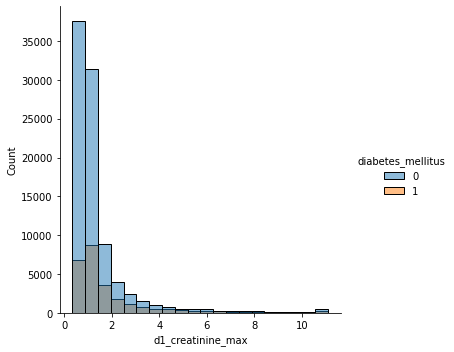

In [ ]:
# sns.displot(data=df,x="d1_bun_max",hue=TARGET_COL,bins=20,aspect=1)   
sns.displot(data=df,x="d1_creatinine_max",hue=TARGET_COL,bins=20,aspect=1)   

In [ ]:
def bunclasst(x):
    if pd.isna(x):
        return np.nan
    x=x*0.357
    if x < 7: return 0 
    elif x >= 7 and x < 20: return 1
    elif x >=20 and x < 25: return 2 
    elif x >= 25 and x < 35: return 3
    elif x >= 35: return 4

In [ ]:
bun_d=["d1_bun_max","d1_bun_min"]
bun_h=["h1_bun_max","h1_bun_min"]
bun_columns=["d1_bun_max","d1_bun_min","h1_bun_max","h1_bun_min"]
df_full["bun_na_h"] = df_full[bun_h].isna().sum(axis=1)
df_full["bun_na_d"] = df_full[bun_h].isna().sum(axis=1)
df_full["bun_na"] = df_full["bun_na_h"] + df_full["bun_na_d"]

#FillNA
# df_full['d1_bun_max']=df_full['d1_bun_max'].fillna(0)
# df_full['d1_bun_min']=df_full['d1_bun_min'].fillna(0)
# df_full['h1_bun_min']=df_full['h1_bun_min'].fillna(0)
# df_full['h1_bun_max']=df_full['h1_bun_max'].fillna(0)

#Create new features
df_full['bun_max_min_d']= df_full['d1_bun_max']-df_full['d1_bun_min']
df_full['bun_max_min_h']= df_full['h1_bun_max']-df_full['h1_bun_min']
df_full['bun_d_h'] = df_full['d1_bun_max']-df_full['h1_bun_max']

df_full['bun_max_class'] = df_full['d1_bun_max'].map(bunclasst)

df_full['bun_min_class'] = df_full['d1_bun_min'].map(bunclasst)

df_full['bun_std']= df_full[bun_columns].std(axis=1)
features_models=features_models + ["bun_na_h","bun_na_d","bun_na",'d1_bun_max',
                       'd1_bun_min','h1_bun_max','h1_bun_min','bun_max_min_d',
                       'bun_max_min_h','bun_d_h','bun_max_class','bun_min_class','bun_std']

In [ ]:
def creatinineclasst(x):
    if pd.isna(x):
        return np.nan
    if x < 1.5: return 0 
    elif x >= 1.5 and x < 3.5: return 1
    elif x >=3.5 and x < 6: return 2 
    elif x >= 6 and x < 10: return 3
    elif x >= 10: return 4

In [ ]:
creatinine_d=["d1_creatinine_max","d1_creatinine_min"]
creatinine_h=["h1_creatinine_max","h1_creatinine_min"]
creatinie_columns=["d1_creatinine_max","d1_creatinine_min","h1_creatinine_max","h1_creatinine_min"]
df_full["creatinine_na_h"] = df_full[creatinine_h].isna().sum(axis=1)
df_full["creatinine_na_d"] = df_full[creatinine_h].isna().sum(axis=1)
df_full["creatinine_na"] = df_full["creatinine_na_h"] + df_full["creatinine_na_d"]

# #FillNA
# df_full['d1_creatinine_max']=df_full['d1_creatinine_max'].fillna(0)
# df_full['d1_creatinine_min']=df_full['d1_creatinine_min'].fillna(0)
# df_full['h1_creatinine_min']=df_full['h1_creatinine_min'].fillna(0)
# df_full['h1_creatinine_max']=df_full['h1_creatinine_max'].fillna(0)

#Create new features
df_full['creatinine_max_min_d']= df_full['d1_creatinine_max']-df_full['d1_creatinine_min']
df_full['creatinine_max_min_h']= df_full['h1_creatinine_max']-df_full['h1_creatinine_min']
df_full['creatinine_d_h'] = df_full['d1_creatinine_max']-df_full['h1_creatinine_max']

df_full['creatinine_max_class'] = df_full['d1_creatinine_max'].map(creatinineclasst)

df_full['creatinine_min_class'] = df_full['d1_creatinine_min'].map(creatinineclasst)

df_full['creatinine_std']= df_full[creatinie_columns].std(axis=1)

features_models=features_models + ["creatinine_na_h","creatinine_na_d","creatinine_na",'d1_creatinine_max',
                       'd1_creatinine_min','h1_creatinine_max','h1_creatinine_min','creatinine_max_min_d',
                       'creatinine_max_min_h','creatinine_d_h','creatinine_max_class','creatinine_min_class','creatinine_apache']


**Process Categorical feats**

In [ ]:
categorical_cols=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','apache_2_diagnosis']
categorical_cols

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_2_diagnosis']

In [ ]:
print(df.columns.tolist())

['Unnamed: 0', 'encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min',

In [ ]:
df.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,...,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,diff_bmi
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,7.633147e-10
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,...,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1,3.552714e-15
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,-4.906653e-09
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,...,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0,3.236593e-10
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,NaN


In [ ]:
#Process frequence of target
# df_1=df[df[TARGET_COL]==1]
for col in categorical_cols:
    col1=col +"_freq_1"
    col2=col +"_freq"
    # df_full[col]=df_full[col].fillna('outlier')
    list_value_unique=df_full[col].unique().tolist()
    for idx_value in list_value_unique:
        # values_1=df_1.loc[df_1[col]==idx_value,col].count()
        values=df_full.loc[df_full[col]==idx_value,col].count()
        # df_full.loc[df_full[col]==idx_value,col1]=values_1
        df_full.loc[df_full[col]==idx_value,col2]=values
        features_models.append(col1)
        features_models.append(col2)


**Process apache 2 apache 3**

In [ ]:

df_full["apache_2_diagnosis"] = df_full["apache_2_diagnosis"].fillna(0)

df_full["int_apache_3j_diag"] =  df_full["apache_3j_diagnosis"].fillna(0).astype(str).str.split(".",expand=True)[0].astype(int)

df_full.tail()[["int_apache_3j_diag","apache_3j_diagnosis","apache_2_diagnosis"]].drop_duplicates()


df["int_apache_3j_diag"] =  df["apache_3j_diagnosis"].fillna(0).astype(str).str.split(".",expand=True)[0].astype(int)

df.tail()[["int_apache_3j_diag","apache_3j_diagnosis","apache_2_diagnosis"]].drop_duplicates()

,int_apache_3j_diag,apache_3j_diagnosis,apache_2_diagnosis
130152,104,104.01,110.0
130153,207,207.01,105.0
130154,102,102.01,114.0
130155,306,306.01,124.0


In [ ]:
col_convert_freq=['gcs_eyes_apache','gcs_motor_apache','gcs_verbal_apache','int_apache_3j_diag']

# df_1=df[df[TARGET_COL]==1]
for col in col_convert_freq:
    col1=col +"_freq_1"
    col2=col +"_freq"
    list_value_unique=df_full[col].unique().tolist()
    for idx_value in list_value_unique:
      # values_1=df_1.loc[df_1[col]==idx_value,col].count()
      values=df_full.loc[df_full[col]==idx_value,col].count()
      # df_full.loc[df_full[col]==idx_value,col1]=values_1
      df_full.loc[df_full[col]==idx_value,col2]=values

**Binning/Caculated score follow apache**

In [ ]:
#Calculate GSC Score
df_full['gsc_score']=df_full['gcs_eyes_apache'] + df_full['gcs_motor_apache'] + df_full['gcs_verbal_apache']


In [ ]:
heart_rate_cols=['heart_rate_apache','d1_heartrate_max','d1_heartrate_min','d1_heartrate_max','h1_heartrate_min','h1_heartrate_max']
binning_cols=[]

#heart_rate Done
for col in heart_rate_cols:
    heart_rate_col_name=col+'_bins'
    binning_cols.append(heart_rate_col_name)
    df_full.loc[(df_full[col] <40) | (df_full[col] >= 180), heart_rate_col_name] = 4
    df_full.loc[((df_full[col] >= 40) & ( df_full[col] <55)) | ( (df_full[col] >= 140) & ( df_full[col] <180)), heart_rate_col_name] = 3
    df_full.loc[((df_full[col] >= 110) & ( df_full[col] <140)) | ( (df_full[col] >= 55) & ( df_full[col] <70)), heart_rate_col_name] = 2
    df_full.loc[(df_full[col] >= 70) & (df_full[col] <110),heart_rate_col_name] = 0
    
#resprate Done
resprate_cols=['resprate_apache','d1_resprate_max','d1_resprate_min','d1_resprate_max','h1_resprate_min','h1_resprate_max']
for col in resprate_cols:
    resprate_cols_name=col+'_bins'
    binning_cols.append(resprate_cols_name)
    df_full.loc[(df_full[col] <6) | (df_full[col] >= 50), resprate_cols_name] = 4
    df_full.loc[(df_full[col] >= 35) & (df_full[col] <50), resprate_cols_name] = 3
    df_full.loc[(df_full[col] >= 6) & (df_full[col] <10), resprate_cols_name] = 2
    df_full.loc[((df_full[col] >= 25) & ( df_full[col] <35)) | ( (df_full[col] >= 10) & ( df_full[col] < 12)), resprate_cols_name] = 1
    df_full.loc[(df_full[col] >= 12) & ( df_full[col] <25) , resprate_cols_name] = 0

#Done_temp
temp_cols=['temp_apache','d1_temp_max','d1_temp_min','d1_temp_max','h1_temp_min','h1_temp_max']
for col in temp_cols:
    temp_cols_name=col+'_bins'
    binning_cols.append(temp_cols_name)
    df_full.loc[(df_full[col] < 30) | (df_full[col] >= 41), temp_cols_name] = 4
    df_full.loc[((df_full[col] >= 39) & ( df_full[col] <41)) | ((df_full[col] >= 30) & ( df_full[col] < 32)), temp_cols_name] = 3
    df_full.loc[(df_full[col] >= 32) & ( df_full[col] < 34), temp_cols_name] = 2
    df_full.loc[((df_full[col] >= 38.5) & ( df_full[col] <39)) | ( (df_full[col] >= 34) & ( df_full[col] < 36)), temp_cols_name] = 1
    df_full.loc[((df_full[col] >= 36) & ( df_full[col] <38.5)) , temp_cols_name] = 0
    


#Sodium done
sodium_cols=['sodium_apache','d1_sodium_max','d1_sodium_min','d1_sodium_max','h1_sodium_min','h1_sodium_max']
for col in sodium_cols:
    sodium_cols_name=col+'_bins'
    binning_cols.append(sodium_cols_name)
    df_full.loc[(df_full[col] <111) | (df_full[col] >= 180), sodium_cols_name] = 4
    df_full.loc[((df_full[col] >= 160) & ( df_full[col] <180))|((df_full[col] >=111) & ( df_full[col] <120)), sodium_cols_name] = 3
    df_full.loc[((df_full[col] >= 155) & ( df_full[col] <160))|((df_full[col] >= 120) & ( df_full[col] <130)), sodium_cols_name] = 2
    df_full.loc[((df_full[col] >= 150) & ( df_full[col] <155)), sodium_cols_name] = 1
    df_full.loc[((df_full[col] >= 130) & ( df_full[col] <150)) , sodium_cols_name] = 0

#Potassium done 
potassium_cols=['d1_potassium_max','d1_potassium_min','d1_potassium_max','h1_potassium_min','h1_potassium_max']
for col in potassium_cols:
    potassium_cols_name=col+'_bins'
    binning_cols.append(potassium_cols_name)
    df_full.loc[(df_full[col] < 2.5) | (df_full[col] >= 7), potassium_cols_name] = 4
    df_full.loc[(df_full[col] >= 6) & ( df_full[col] <7), potassium_cols_name] = 3
    df_full.loc[((df_full[col] >= 2.5) & ( df_full[col] <3)), potassium_cols_name] = 2
    df_full.loc[((df_full[col] >= 5.5) & ( df_full[col] <6)) | ( (df_full[col] >= 3) & ( df_full[col] < 3.5)), potassium_cols_name] = 1
    df_full.loc[(df_full[col] >= 3.5) & ( df_full[col] < 5.5) , potassium_cols_name] = 0
    
df_full['potassium_apache_bins']=0
df_full.loc[df_full['d1_potassium_max_bins']<df_full['d1_potassium_min_bins'],'potassium_apache_bins']=df_full.loc[df_full['d1_potassium_max_bins']<df_full['d1_potassium_min_bins'],'d1_potassium_min_bins']
df_full.loc[df_full['d1_potassium_max_bins']>=df_full['d1_potassium_min_bins'],'potassium_apache_bins']=df_full.loc[df_full['d1_potassium_max_bins']>=df_full['d1_potassium_min_bins'],'d1_potassium_max_bins']
binning_cols.append('potassium_apache_bins')

#Hematocrit cols
hematocrit_cols=['hematocrit_apache','d1_hematocrit_max','d1_hematocrit_min','h1_hematocrit_max','h1_hematocrit_min']    
for col in hematocrit_cols:
    hematocrit_cols_name=col+'_bins'
    binning_cols.append(hematocrit_cols_name)
    df_full.loc[(df_full[col] < 20) | (df_full[col] >= 60), hematocrit_cols_name] = 4
    df_full.loc[((df_full[col] >= 50) & ( df_full[col] <60)) | ( (df_full[col] >= 20) & ( df_full[col] <30)), hematocrit_cols_name] = 2
    df_full.loc[(df_full[col] >= 46) & ( df_full[col] <50), hematocrit_cols_name] = 1
    df_full.loc[(df_full[col] >= 30) & ( df_full[col] <46) , hematocrit_cols_name] = 0
#creatinine cols done
creatinine_cols=['creatinine_apache','d1_creatinine_max','d1_creatinine_min','h1_creatinine_max','h1_creatinine_min']    
for col in creatinine_cols:
    creatinine_cols_name=col+'_bins'
    binning_cols.append(creatinine_cols_name)
    df_full.loc[(df_full[col] >= 3.5), creatinine_cols_name] = 4
    df_full.loc[(df_full[col] >= 2) & ( df_full[col] <3.5), creatinine_cols_name] = 3
    df_full.loc[((df_full[col] >= 1.5) & ( df_full[col] <=2)) | ( (df_full[col] < 0.6)), creatinine_cols_name] = 2
    df_full.loc[(df_full[col] >= 0.6) & ( df_full[col] <1.5) , creatinine_cols_name] = 0
df_full.loc[df_full['arf_apache']==1,'creatinine_apache_bins']=df_full.loc[df_full['arf_apache']==1,'creatinine_apache_bins']*2


#Done wbc
wbc_cols=['wbc_apache','d1_wbc_max','d1_wbc_min','h1_wbc_max','h1_wbc_min']    
for col in wbc_cols:
    wbc_cols_name=col+'_bins'
    binning_cols.append(wbc_cols_name)
    df_full.loc[((df_full[col] >= 40)) | ( (df_full[col] < 1)), wbc_cols_name] = 4
    df_full.loc[((df_full[col] >= 20) & ( df_full[col] <40))|((df_full[col] >= 1) & ( df_full[col] <3)), wbc_cols_name] = 2
    df_full.loc[((df_full[col] >= 15) & ( df_full[col] <20)), wbc_cols_name] = 1
    df_full.loc[((df_full[col] >= 3) & ( df_full[col] <15)) , wbc_cols_name] = 0

#Done age
age_cols=['age']    
for col in age_cols:
    age_cols_name=col+'_bins'
    binning_cols.append(age_cols_name)
    df_full.loc[(df_full[col] > 74), age_cols_name] = 6
    df_full.loc[(df_full[col] >= 65) & ( df_full[col] <=74), age_cols_name] = 5
    df_full.loc[(df_full[col] >= 55) & ( df_full[col] <=64), age_cols_name] = 3
    df_full.loc[(df_full[col] >= 45) & ( df_full[col] <=54), age_cols_name] = 2
    df_full.loc[(df_full[col] <=44) , age_cols_name] = 0
#Done map
map_cols=['map_apache']    
for col in map_cols:
    cols_name=col+'_bins'
    binning_cols.append(cols_name)
    df_full.loc[(df_full[col] <= 49) | (df_full[col] >159), cols_name] = 4
    df_full.loc[((df_full[col] >109) & ( df_full[col] <=129)) | ((df_full[col] > 49) & ( df_full[col] <=69 )), cols_name] = 2
    df_full.loc[(df_full[col] > 129) & ( df_full[col] <= 159), cols_name] = 3
    df_full.loc[((df_full[col] >69) & ( df_full[col] <=109)) , cols_name] = 0
df_full['gsc_score']=df_full['gcs_eyes_apache'] + df_full['gcs_motor_apache'] + df_full['gcs_verbal_apache']
df_full['gsc_score_bins']=15-df_full['gsc_score']
binning_cols.append('gsc_score_bins') 
apache_cols=['heart_rate_apache','resprate_apache','temp_apache','sodium_apache','potassium_apache','hematocrit_apache','creatinine_apache','wbc_apache','age','gsc_score','map_apache']
df_full['apache_full']=0
for col in apache_cols:
    col_name=col+"_bins"
    df_full['apache_full']=df_full['apache_full']+df_full[col_name]
df_full['has_history']=df_full['aids']+df_full['cirrhosis']+df_full['hepatic_failure']+df_full['immunosuppression']+df_full['leukemia']+df_full['lymphoma']+df_full['solid_tumor_with_metastasis']
df_full['apache_hist']=0
df_full.loc[(df_full['elective_surgery']==1)&(df_full['has_history']>0),'apache_hist']=2
df_full.loc[(df_full['elective_surgery']==0)&(df_full['has_history']>0),'apache_hist']=5
df_full.loc[(df_full['apache_post_operative']==1)&(df_full['has_history']>0),'apache_hist']=5
df_full.loc[(df_full['apache_post_operative']==0)&(df_full['has_history']>0),'apache_hist']=2
df_full.loc[(df_full['has_history']==0),'apache_hist']=0

df_full['apache_full']=df_full['apache_full']+df_full['apache_hist']

**Process heart-rate vs blood pressure**

In [ ]:
def mapclasst(x):
    if pd.isna(x):
        return np.nan
    if x < 60: return -2 
    elif x >= 60 and x < 70: return -1
    elif x >=70 and x < 100: return 0 
    elif x >= 100 and x < 120: return 1
    elif x >= 120 and x < 140: return 2
    elif x >= 140 and x < 180: return 3
    elif x >= 180: return 4

In [ ]:
#MAP is average blood pressure
df_full['map_new_min']=(2*df_full['d1_diasbp_min'] + df_full['d1_sysbp_min'])/3
df_full['map_new_max']=(2*df_full['d1_diasbp_max'] + df_full['d1_sysbp_max'])/3
df_full['map_new_diff']=df_full['map_new_max']-df_full['map_new_min']
df_full['map_max_class']=df_full['map_new_max'].map(mapclasst)
df_full['map_min_class']=df_full['map_new_min'].map(mapclasst)
df_full['map_class']=df_full['map_max_class']+ df_full['map_min_class']

**Process combining features**

In [ ]:
df_full["d1_resprate_div_mbp_min"] = df_full["d1_resprate_min"].div(df_full["d1_mbp_min"])
df_full["d1_resprate_div_sysbp_min"] = df_full["d1_resprate_min"].div(df_full["d1_sysbp_min"])
df_full["d1_lactate_min_div_diasbp_min"] = df_full["d1_lactate_min"].div(df_full["d1_diasbp_min"])
df_full["d1_heartrate_min_div_d1_sysbp_min"] = df_full["d1_heartrate_min"].div(df_full["d1_sysbp_min"])
df_full["d1_hco3_div"]= df_full["d1_hco3_max"].div(df_full["d1_hco3_min"])

df_full["d1_resprate_times_resprate"] = df_full["d1_resprate_min"].multiply(df_full["d1_resprate_max"])

df_full["left_average_spo2"] = (2*df_full["d1_spo2_max"] + df_full["d1_spo2_min"])/3

In [ ]:
df_full["total_chronic"] = df_full[["aids","cirrhosis",  'hepatic_failure']].sum(axis=1)

df_full["total_cancer_immuno"] = df_full[[ 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].sum(axis=1)

df_full["has_complicator"] = df_full[["aids","cirrhosis", 'hepatic_failure',
                            'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].max(axis=1)

In [ ]:
#age vs bmi vs glucose high level
df_full['gluco_high_risk']=df_full['glu_risk_140']+ df_full['glu_risk_200']


df_full['age_glu_l']= df_full['ageclass'] + df_full['gluco_high_risk']


df_full['bmi_glu_l']= df_full['weightclass'] + df_full['gluco_high_risk']


df_full['age_glu_l_class']= df_full['ageclass'] + df_full['glu_sum_class']

df_full['bmi_glu_l_class']= df_full['weightclass'] + df_full['glu_sum_class']



df_full['age_bmi_glu_l']= df_full['ageclass']  + df_full['weightclass'] + df_full['gluco_high_risk']

df_full['age_bmi_glu_l_class']= df_full['ageclass']  + df_full['weightclass'] + df_full['glu_sum_class']


df_full['age_bmi_glu_max_d'] = df_full['ageclass']  + df_full['weightclass'] + df_full['d1_glucose_max']
df_full['age_bmi_glu_max_h'] = df_full['ageclass']  + df_full['weightclass'] + df_full['h1_glucose_max']

df_full['creatinine_class'] = df_full['creatinine_max_class'] + df_full['creatinine_min_class']

df_full['bun_class'] = df_full['bun_max_class'] + df_full['bun_min_class'] 

df_full['glu_bun'] = df_full['gluco_high_risk'] + df_full['bun_class'] 

df_full['glu_cre'] = df_full['gluco_high_risk'] + df_full['creatinine_class'] 

df_full['glu_bun_class'] = df_full['glu_sum_class'] + df_full['bun_class'] 

df_full['glu_cre_class'] = df_full['glu_sum_class'] + df_full['creatinine_class'] 

df_full['glu_map_l']=df_full['map_class']+df_full['gluco_high_risk']
df_full['glu_map_l_class']=df_full['map_class']+df_full['glu_sum_class']

df_full['age_weight']=df_full['age']*df_full['weight']
df_full['weight_glucose']=df_full['d1_glucose_max']*df_full['weight']
df_full['bmi_glucose']=df_full['d1_glucose_max']*df_full['bmi']


df_full['age_glu_l_1']= df_full['ageclass'] * df_full['gluco_high_risk']


df_full['bmi_glu_l_1']= df_full['weightclass'] * df_full['gluco_high_risk']


df_full['age_glu_l_1_class']= df_full['ageclass'] * df_full['glu_sum_class']

df_full['bmi_glu_l_1_class']= df_full['weightclass'] * df_full['glu_sum_class']



df_full['age_bmi_glu_l_1']= df_full['ageclass']  * df_full['weightclass'] * df_full['gluco_high_risk']

df_full['age_bmi_glu_l_1_class']= df_full['ageclass']  * df_full['weightclass'] * df_full['glu_sum_class']


df_full['age_bmi_glu_max_d_1'] = df_full['ageclass']  * df_full['weightclass'] * df_full['d1_glucose_max']
df_full['age_bmi_glu_max_h_1'] = df_full['ageclass']  * df_full['weightclass'] * df_full['h1_glucose_max']

df_full['creatinine_class'] = df_full['creatinine_max_class'] * df_full['creatinine_min_class']

df_full['bun_class_1'] = df_full['bun_max_class'] * df_full['bun_min_class'] 

df_full['glu_bun_1'] = df_full['gluco_high_risk'] * df_full['bun_class'] 

df_full['glu_cre_1'] = df_full['gluco_high_risk'] * df_full['creatinine_class'] 

df_full['glu_bun_class_1'] = df_full['glu_sum_class'] * df_full['bun_class'] 

df_full['glu_cre_class_1'] = df_full['glu_sum_class'] * df_full['creatinine_class'] 

df_full['glu_map_l_1']=df_full['map_class']*df_full['gluco_high_risk']
df_full['glu_map_l_1_class']=df_full['map_class']*df_full['glu_sum_class']

df_full['eyes_glu']=df_full['gcs_eyes_apache']*df_full['d1_glucose_max']

df_full['glu_map']=df_full['map_new_max']*df_full['d1_glucose_max']

df_full['heart_glu']=df_full['d1_heartrate_max']*df_full['d1_glucose_max']

In [ ]:
bin_cols = [col for col in df_full.columns if (('bins' in col))]
bin_cols
df_full['heart_glu_max_mul_risk']=df_full['d1_heartrate_max_bins']*df_full['gluco_high_risk']
df_full['heart_glu_max_mul']=df_full['d1_heartrate_max_bins']*df_full['d1_glucose_max']

df_full['resprate_glu_max_mul_risk']=df_full['d1_resprate_max_bins']*df_full['gluco_high_risk']
df_full['resprate_glu_max_mul']=df_full['d1_resprate_max_bins']*df_full['d1_glucose_max']

df_full['creatinine_glu_max_mul_risk']=df_full['d1_creatinine_max_bins']*df_full['gluco_high_risk']
df_full['creatinine_glu_max_mul']=df_full['d1_creatinine_max_bins']*df_full['d1_glucose_max']



In [ ]:
list_cols=df_full.columns
list_cols

Index(['Unnamed: 0', 'encounter_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source',
       ...
       'glu_map_l_1_class', 'eyes_glu', 'glu_map', 'heart_glu',
       'heart_glu_max_mul_risk', 'heart_glu_max_mul',
       'resprate_glu_max_mul_risk', 'resprate_glu_max_mul',
       'creatinine_glu_max_mul_risk', 'creatinine_glu_max_mul'],
      dtype='object', length=1363)

In [ ]:
df_full.replace([np.inf, -np.inf], np.nan,inplace=True)

In [ ]:
important_cols=['gender','age','ageclass','weightclass','bun_max_class','d1_creatinine_max_bins']
important_cols=important_cols+['ethnicity','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','apache_2_diagnosis','int_apache_3j_diag']
df['ageclass']=df_full.loc[df_full[TARGET_COL].notnull(),'ageclass']
df['weightclass']=df_full.loc[df_full[TARGET_COL].notnull(),'weightclass']
df['bun_max_class']=df_full.loc[df_full[TARGET_COL].notnull(),'bun_max_class']
df['d1_creatinine_max_bins'] =df_full.loc[df_full[TARGET_COL].notnull(),'d1_creatinine_max_bins']
# df_1=df[df[TARGET_COL]==1]
for col in important_cols:
    col1=col +"_mean_glucose_1"
    col2=col +"_mean_glucose"
    col3=col +"_std_glucose_1"
    col4=col +"_std_glucose"
    list_value_unique=df_full[col].unique().tolist()
    for idx_value in list_value_unique:
        # mean_val_1=df_1.loc[df_1[col]==idx_value,'d1_glucose_max'].mean()
        mean_val=df_full.loc[df_full[col]==idx_value,'d1_glucose_max'].mean()
        # std_val_1=df_1.loc[df_1[col]==idx_value,'d1_glucose_max'].std()
        std_val=df_full.loc[df_full[col]==idx_value,'d1_glucose_max'].std()
        # df_full.loc[df_full[col]==idx_value,col1]=mean_val_1
        df_full.loc[df_full[col]==idx_value,col2]=mean_val
        # df_full.loc[df_full[col]==idx_value,col3]=std_val_1
        df_full.loc[df_full[col]==idx_value,col4]=std_val
        features_models.append(col1)
        features_models.append(col2)

In [ ]:
len(df_full.columns)

1389

**Isolation Forest features**

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=120, max_samples=1100, max_features=0.9, n_jobs=3,behaviour="new",contamination='auto')

clf2 = IsolationForest(n_estimators=150, max_samples=600, max_features=1.0, n_jobs=3,behaviour="new", contamination='auto')

In [ ]:
# #Create data for isolation forest
# X_IF=df_full
# X_IF = X_IF.drop(TARGET_COL,axis=1)
# X_IF = X_IF.drop(USE_LESS,axis=1)
# X_IF = X_IF.drop(categorical_cols,axis=1)
# X_IF.columns
# # X = X.fillna(-1)
# # X = X*1  ## force booleans to be integers

# X_IF.head()

# X_IF.dropna(thresh = 1000, axis = 1,inplace=True)


In [ ]:
# # Creat isolation forest feats
# clf.fit(X_IF.fillna(-1))
# df_full["isolation_forest_score_1"] = clf.score_samples(X_IF.fillna(-1))



In [ ]:
# thresh = len(X_IF) * .5
# X_IF.dropna(thresh = thresh, axis = 1,inplace=True)
# X2=X_IF.fillna(X_IF.median())
# clf2.fit(X2)
# df_full["isolation_forest_score_2"] = clf2.score_samples(X2)

In [ ]:
# df_full["isolation_forest_score_2"]

In [ ]:
df_full.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2fio2ratio_apache,arterial_ph_apache,resprate_apache,...,glu_cre_1,glu_bun_class_1,glu_cre_class_1,glu_map_l_1,glu_map_l_1_class,eyes_glu,glu_map,heart_glu,heart_glu_max_mul_risk,heart_glu_max_mul,resprate_glu_max_mul_risk,resprate_glu_max_mul,creatinine_glu_max_mul_risk,creatinine_glu_max_mul,gender_mean_glucose,gender_std_glucose,age_mean_glucose,age_std_glucose,ageclass_mean_glucose,ageclass_std_glucose,weightclass_mean_glucose,weightclass_std_glucose,bun_max_class_mean_glucose,bun_max_class_std_glucose,d1_creatinine_max_bins_mean_glucose,d1_creatinine_max_bins_std_glucose,ethnicity_mean_glucose,ethnicity_std_glucose,hospital_admit_source_mean_glucose,hospital_admit_source_std_glucose,icu_admit_source_mean_glucose,icu_admit_source_std_glucose,icu_stay_type_mean_glucose,icu_stay_type_std_glucose,icu_type_mean_glucose,icu_type_std_glucose,apache_2_diagnosis_mean_glucose,apache_2_diagnosis_std_glucose,int_apache_3j_diag_mean_glucose,int_apache_3j_diag_std_glucose
0,1,214826,118,68.0,22.732803,0,Caucasian,1,180.3,3,Floor,229,0,CTICU,0.632200,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,2,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,2.0,NaN,NaN,-4.0,NaN,336.0,14952.000000,19992.0,4.0,336.0,2.0,168.0,6.0,504.0,173.308751,85.024388,179.850215,79.212435,179.387199,82.254617,164.584950,84.620231,189.480256,96.155087,207.491239,112.307548,172.197936,83.726956,170.770291,78.572451,171.128214,79.488530,173.890902,86.161669,172.421101,62.850957,179.740377,89.121991,180.502164,90.681812
1,2,246060,81,77.0,27.421875,0,Caucasian,0,160.0,3,Floor,218,0,Med-Surg ICU,0.716624,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,...,0.0,0.0,0.0,-3.0,-11.0,0.0,16868.333333,17110.0,6.0,290.0,3.0,145.0,0.0,0.0,174.762669,87.674546,174.364689,75.372581,170.514239,75.474330,170.951360,83.237618,158.139059,69.835679,166.596561,77.256928,172.197936,83.726956,170.770291,78.572451,171.128214,79.488530,173.890902,86.161669,176.114048,90.772450,177.203204,77.706172,177.203204,77.706172
2,3,276985,118,25.0,31.952749,0,Caucasian,0,172.7,2,Accident & Emergency,235,0,Med-Surg ICU,0.500174,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,2,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,174.762669,87.674546,152.037891,90.195261,160.850774,97.513830,180.081654,85.866818,NaN,NaN,NaN,NaN,172.197936,83.726956,176.541807,97.906952,176.371743,96.651483,173.890902,86.161669,176.114048,90.772450,129.142224,57.681773,129.142224,57.681773
3,4,262220,118,81.0,22.635548,1,Caucasian,0,165.1,5,Operating Room / Recovery,229,0,CTICU,0.500174,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,3,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,...,NaN,NaN,NaN,-4.0,NaN,555.0,15663.333333,21460.0,4.0,370.0,0.0,0.0,NaN,NaN,174.762669,87.674546,170.315857,75.075498,170.514239,75.474330,164.584950,84.620231,NaN,NaN,NaN,NaN,172.197936,83.726956,171.501829,54.675042,170.527931,56.507817,173.890902,86.161669,172.421101,62.850957,172.820986,42.891644,169.479728,42.263533
4,5,201746,33,19.0,NaN,0,Caucasian,1,188.0,10,Accident & Emergency,225,0,Med-Surg ICU,0.518394,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,173.308751,85.024388,165.362542,108.826260,163.753575,101.546158,NaN,NaN,NaN,NaN,NaN,NaN,172.197936,83.726956,174.6

In [ ]:
X_train=df_full[df_full[TARGET_COL].notnull()]
X_test=df_full[df_full[TARGET_COL].isnull()]


In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

X_train_1=X_train.fillna(X_train.mean())
X_test_1=X_test.fillna(X_train.mean())

features_added_to_knn=['d1_glucose_max','h1_glucose_max','ageclass','weightclass','weight',
                       'd1_glucose_min','h1_glucose_min','d1_bun_max','d1_bun_min',
                       'd1_creatinine_max','d1_creatinine_min','d1_heartrate_max','d1_heartrate_min'
                       ,'glucose_d1_value_range','glucose_h1_value_range','new_gender','age','map_new_max','map_new_min']
X_train_1=X_train_1[features_added_to_knn]
X_test_1=X_test_1[features_added_to_knn]

scaler = StandardScaler()

X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.fit_transform(X_test_1)





In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=16,n_jobs = 1000)
knn1.fit(X_train_1,X_train[TARGET_COL])
result_train = knn1.predict_proba(X_train_1)
result_test =knn1.predict_proba(X_test_1)
tempTrain = pd.DataFrame(result_train)
tempTest = pd.DataFrame(result_test)

df_full.loc[df_full[TARGET_COL].notnull(),'knn_value_16']=tempTrain[1]
df_full.loc[df_full[TARGET_COL].isnull(),'knn_value_16']=tempTest[1]

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=64,n_jobs = 10000)
knn1.fit(X_train_1,X_train[TARGET_COL])
result_train = knn1.predict_proba(X_train_1)
result_test =knn1.predict_proba(X_test_1)
tempTrain = pd.DataFrame(result_train)
tempTest = pd.DataFrame(result_test)

df_full.loc[df_full[TARGET_COL].notnull(),'knn_value_64']=tempTrain[1]
df_full.loc[df_full[TARGET_COL].isnull(),'knn_value_64']=tempTest[1]

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=512,n_jobs = 1000)
knn1.fit(X_train_1,X_train[TARGET_COL])
result_train = knn1.predict_proba(X_train_1)
result_test =knn1.predict_proba(X_test_1)
tempTrain = pd.DataFrame(result_train)
tempTest = pd.DataFrame(result_test)

df_full.loc[df_full[TARGET_COL].notnull(),'knn_value_512']=tempTrain[1]
df_full.loc[df_full[TARGET_COL].isnull(),'knn_value_512']=tempTest[1]

In [ ]:
df_full.drop_duplicates( keep='first')

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2fio2ratio_apache,arterial_ph_apache,resprate_apache,...,glu_map_l_1,glu_map_l_1_class,eyes_glu,glu_map,heart_glu,heart_glu_max_mul_risk,heart_glu_max_mul,resprate_glu_max_mul_risk,resprate_glu_max_mul,creatinine_glu_max_mul_risk,creatinine_glu_max_mul,gender_mean_glucose,gender_std_glucose,age_mean_glucose,age_std_glucose,ageclass_mean_glucose,ageclass_std_glucose,weightclass_mean_glucose,weightclass_std_glucose,bun_max_class_mean_glucose,bun_max_class_std_glucose,d1_creatinine_max_bins_mean_glucose,d1_creatinine_max_bins_std_glucose,ethnicity_mean_glucose,ethnicity_std_glucose,hospital_admit_source_mean_glucose,hospital_admit_source_std_glucose,icu_admit_source_mean_glucose,icu_admit_source_std_glucose,icu_stay_type_mean_glucose,icu_stay_type_std_glucose,icu_type_mean_glucose,icu_type_std_glucose,apache_2_diagnosis_mean_glucose,apache_2_diagnosis_std_glucose,int_apache_3j_diag_mean_glucose,int_apache_3j_diag_std_glucose,knn_value_16,knn_value_64,knn_value_512
0,1,214826,118,68.0,22.732803,0,Caucasian,1,180.3,3,Floor,229,0,CTICU,0.632200,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,2,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,-4.0,NaN,336.0,14952.000000,19992.0,4.0,336.0,2.0,168.0,6.0,504.0,173.308751,85.024388,179.850215,79.212435,179.387199,82.254617,164.584950,84.620231,189.480256,96.155087,207.491239,112.307548,172.197936,83.726956,170.770291,78.572451,171.128214,79.488530,173.890902,86.161669,172.421101,62.850957,179.740377,89.121991,180.502164,90.681812,0.2500,0.187500,0.152344
1,2,246060,81,77.0,27.421875,0,Caucasian,0,160.0,3,Floor,218,0,Med-Surg ICU,0.716624,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,...,-3.0,-11.0,0.0,16868.333333,17110.0,6.0,290.0,3.0,145.0,0.0,0.0,174.762669,87.674546,174.364689,75.372581,170.514239,75.474330,170.951360,83.237618,158.139059,69.835679,166.596561,77.256928,172.197936,83.726956,170.770291,78.572451,171.128214,79.488530,173.890902,86.161669,176.114048,90.772450,177.203204,77.706172,177.203204,77.706172,0.1875,0.109375,0.099609
2,3,276985,118,25.0,31.952749,0,Caucasian,0,172.7,2,Accident & Emergency,235,0,Med-Surg ICU,0.500174,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,2,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,174.762669,87.674546,152.037891,90.195261,160.850774,97.513830,180.081654,85.866818,NaN,NaN,NaN,NaN,172.197936,83.726956,176.541807,97.906952,176.371743,96.651483,173.890902,86.161669,176.114048,90.772450,129.142224,57.681773,129.142224,57.681773,0.0000,0.015625,0.046875
3,4,262220,118,81.0,22.635548,1,Caucasian,0,165.1,5,Operating Room / Recovery,229,0,CTICU,0.500174,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,3,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,...,-4.0,NaN,555.0,15663.333333,21460.0,4.0,370.0,0.0,0.0,NaN,NaN,174.762669,87.674546,170.315857,75.075498,170.514239,75.474330,164.584950,84.620231,NaN,NaN,NaN,NaN,172.197936,83.726956,171.501829,54.675042,170.527931,56.507817,173.890902,86.161669,172.421101,62.850957,172.820986,42.891644,169.479728,42.263533,0.0625,0.125000,0.138672
4,5,201746,33,19.0,NaN,0,Caucasian,1,188.0,10,Accident & Emergency,225,0,Med-Surg ICU,0.518394,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,173.308751,85.024388,165.362542,108.826260,163.753575,101.546158,NaN,NaN,NaN,

In [ ]:
df_full.to_csv(folder_path +'Wids2021_full_feature_v5.csv')

In [ ]:
df_full.shape

(140391, 1392)

**End feature engineering**

#Modeling



In [ ]:
train=df_full[df_full[TARGET_COL].notnull()]
test=df_full[df_full[TARGET_COL].isnull()]


In [ ]:
def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':

                if (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()
train.shape, test.shape

Mem. usage decreased to 359.35 MB (70.1 % reduction)


KeyboardInterrupt: ignored

In [ ]:
train.columns

In [ ]:
y=train[TARGET_COL]
train = train.drop(TARGET_COL, axis=1)
test = test.drop(TARGET_COL, axis=1)

train = train.drop(['readmission_status','encounter_id','hospital_id'], axis=1)
test = test.drop(['readmission_status','encounter_id','hospital_id'], axis=1)


train = train.drop(categorical_cols, axis=1)
test = test.drop(categorical_cols, axis=1)


In [ ]:
evals = {}
evals['lgb'] = {}
lparams = {}

seeds = [0, 1]
nfold = [5, 5]
stratified=[False, False]
shuffle=[True, True]
n_estimators = 30000
early_stopping_rounds = 300
verbose_eval = 0
learning_rate = 0.01
reg_alpha = [0.4, 1]
reg_lambda = [0.7, 1]
subsample = [0.45, 1]
colsample_bytree = [0.3, 0.225]
max_depth = -1
verbose = -1
n_jobs = 4

lparams[0] = dict(boosting_type='gbdt',
               objective='binary',
               metric='auc',
               learning_rate= learning_rate,
               num_leaves= 200,
               max_bin=500,
               min_child_weight= 0.035,
               subsample= subsample[0],
               colsample_bytree= colsample_bytree[0],
               min_data_in_leaf= 150,
               max_depth= max_depth,
               bagging_seed= seeds[0],
               reg_alpha= reg_alpha[0],
               reg_lambda= reg_lambda[0],
               verbose= verbose,
               seed= seeds[0],
               n_jobs= n_jobs,
               device='gpu',
              gpu_platform_id=0,
              gpu_device_id=0,)

lparams[1] = dict(boosting_type='gbdt',
               objective='binary',
               metric='auc',
               learning_rate= learning_rate,
               n_estimators= n_estimators,
               subsample= subsample[1],
               colsample_bytree= colsample_bytree[1],
               max_depth= max_depth,
               bagging_seed= seeds[1],
               reg_alpha= reg_alpha[1],
               reg_lambda= reg_lambda[1],
               verbose= verbose,
               seed= seeds[1],
               n_jobs= n_jobs,
               device='gpu',
              gpu_platform_id=0,
              gpu_device_id=0,)

test_preds = np.zeros(len(test))    
dtrain = lgb.Dataset(train, y)
dtest = test.copy()
testlen = test.shape[0]
del train, test, trainf, testf
gc.collect()



In [ ]:
!pip install lightgbm --upgrade

In [ ]:
for i, seed in enumerate(seeds):
    print(f'Training Model with SEED : {seed}')
    evals['lgb'][i] = lgb.cv(lparams[i],
                             dtrain,
                             nfold=nfold[i], 
                             stratified=stratified[i],
                             shuffle=shuffle[i],
                             num_boost_round=n_estimators,
                             early_stopping_rounds=early_stopping_rounds,
                             verbose_eval=verbose_eval,
                             seed = seed,
                             show_stdv=True)
    print(f'SEED {i} Average fold  AUC {np.round(max(evals["lgb"][i]["auc-mean"]),5)}')
    test_preds += stats.rankdata(np.mean(evals['lgb'][i]['cvbooster'].predict(dtest, num_iteration=evals['lgb'][i]['cvbooster'].best_iteration), axis=0)) / (testlen * len(seeds))

In [ ]:
submission = pd.DataFrame.from_dict({
    'encounter_id':test_id,
    'diabetes_mellitus':test_preds,
})
submission.to_csv('submission_linhntn_lightGBM_2.csv', index=False)

In [ ]:
Getting feature importances

In [ ]:
X_train=df_full[df_full[TARGET_COL].notnull()]
X_test=df_full[df_full[TARGET_COL].isnull()]


X_train_1=X_train.fillna(X_train.mean())
X_test_1=X_test.fillna(X_train.mean())



In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=512,criterion='gini',max_features='auto',min_samples_split=20,max_depth=15)
rfc.fit(X_train,y_train)

# TRASH


In [ ]:
features_added_to_model1= ['apache_3','NA_info','elective_surgery','pre_icu_los_days','readmission_status','apache_post_operative','gender','d1_heartrate_max','d1_heartrate_min','d1_sysbp_max','d1_sysbp_min','d1_diasbp_max','d1_diasbp_min','d1_mbp_max','d1_mbp_min','d1_spo2_max','d1_spo2_min','d1_resprate_max','d1_resprate_min','arf_apache','intubated_apache','ventilated_apache','heart_rate_apache','map_apache','d1_sysbp_noninvasive_max','d1_sysbp_noninvasive_min','gcs_unable_apache','d1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min','apache_3j_diagnosis','resprate_apache','height','d1_mbp_noninvasive_max','d1_mbp_noninvasive_min','apache_2_diagnosis','apache_3j_bodysystem','apache_2_bodysystem','gcs_eyes_apache','gcs_motor_apache','gcs_verbal_apache','d1_temp_max','d1_temp_min','weight','bmi','temp_apache','age','d1_glucose_max','d1_glucose_min','apache_4a_hospital_death_prob','apache_4a_icu_death_prob','d1_potassium_max','d1_potassium_min','d1_creatinine_max','d1_creatinine_min','d1_sodium_max','d1_sodium_min','d1_bun_max','d1_bun_min','glucose_apache','d1_hematocrit_max','d1_hematocrit_min','d1_hemaglobin_max','d1_hemaglobin_min','d1_calcium_max','d1_calcium_min','d1_wbc_max','d1_wbc_min','d1_platelets_max','d1_platelets_min','d1_hco3_max','d1_hco3_min','sodium_apache','creatinine_apache','bun_apache','hematocrit_apache','hospital_admit_source','wbc_apache']

#features_added_to_model1+threshold_bin_cols+binning_cols+new_features_list_add_to_model
features_added_to_model1=list(set(features_added_to_model1))

In [ ]:
len(features_added_to_model1)

In [ ]:
features_added_to_model1=features_added_to_model1+binning_cols
len(features_added_to_model1)

In [ ]:
features_added_to_knn=['apache_4a_icu_death_prob','apache_4a_hospital_death_prob','ventilated_apache','d1_spo2_min','d1_sysbp_min','d1_sysbp_noninvasive_min','gcs_motor_apache','gsc_score','d1_bun_min','apache_3j_diagnosis','age','d1_bun_max','d1_heartrate_min','d1_platelets_min','d1_resprate_max','d1_resprate_min','d1_temp_min','d1_heartrate_max','map_new','d1_mbp_min','d1_temp_max','pre_icu_los_days']

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=100)
# knn.fit(df[features_added_to_knn],df[TARGET_COL])

In [ ]:
# df['knn_value_1']=knn.predict_proba(df[features_added_to_knn])[:,1]
# df['knn_value_0']=knn.predict_proba(df[features_added_to_knn])[:,0]

In [ ]:
# test['knn_value_1']=knn.predict_proba(test[features_added_to_knn])[:,1]
# test['knn_value_0']=knn.predict_proba(test[features_added_to_knn])[:,0]

In [ ]:
# features_added_to_model1.append('knn_value_1')
# features_added_to_model1.append('knn_value_0')

In [ ]:
# ncols=len(df.columns)
# df1 = df.iloc[:,3:ncols]
features_added_to_model1=list(set(features_added_to_model1))
df1=df

In [ ]:
features_added_to_model_2=['apache_4a_icu_death_prob','apache_4a_hospital_death_prob','4a_plus','4a_diff','ventilated_apache','gcs_motor_apache','gsc_score_bins','gcs_verbal_apache','gsc_score','apache_3','gcs_eyes_apache','temp_apache_bins','apache_full','d1_bun_max','apache_2_diagnosis','intubated_apache','map_apache_bins','d1_sysbp_min','d1_bun_min','d1_sysbp_noninvasive_min','wbc_apache_bins','creatinine_apache_bins','apache_3j_diagnosis','apache_2_bodysystem','d1_spo2_min','map_new','d1_mbp_min','bun_apache','d1_mbp_noninvasive_min','d1_creatinine_max','age_bins','d1_resprate_max','hospital_admit_source','heart_rate_apache_bins','potassium_apache_bins','elective_surgery','resprate_apache','d1_diasbp_min','resprate_apache_bins','hematocrit_apache_bins','d1_creatinine_min','apache_3j_bodysystem','d1_potassium_min_bins','d1_heartrate_max','heart_resp_plus','creatinine_apache','apache_post_operative','d1_diasbp_noninvasive_min','heart_rate_apache','map_apache','temp_apache','gender','d1_potassium_max_bins','d1_temp_min','apache_hist','NA_info','d1_hco3_min','d1_resprate_min','age']

In [ ]:
 df2=df1


In [ ]:
features_added_to_model_2=features_added_to_model1

In [ ]:
## useful "hidden" function - df._get_numeric_data()  - returns only numeric columns from a pandas dataframe. Useful for scikit learn models! 

Y_full = df2[TARGET_COL]
# Y_add_test=df_minor_to_add_test[TARGET_COL]

In [ ]:
# X_full=X_full.fillna(0)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X_full)
# X_full_scale=scaler.transform(X_full)
# X_full_1=pd.DataFrame(X_full_scale,columns=X_full.columns)

In [ ]:
X_full_1=X_full

In [ ]:
len(X_full_1.columns)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full_1, Y_full, test_size=0.2, random_state=8888)



In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule(random_state=39) 
  
X_train_res, y_train_res = ncr.fit_sample(X_train, y_train.ravel()) 




print('After Undersampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

In [ ]:
from imblearn.combine import SMOTETomek
sme = SMOTEENN(random_state=42,sampling_strategy=1)
X_res, y_res = sme.fit_resample(X_train_res, y_train_res.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))

In [ ]:
X_train_res_1= pd.DataFrame(X_res,columns=X_train.columns)
y_train_res=y_res

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=512,criterion='gini', max_depth=25, min_samples_split=100,min_samples_leaf=10,max_features='auto',random_state=1235)
rfc.fit(X_train_res_1,y_train_res)

In [ ]:
import xgboost as xgb
xgbC = xgb.XGBClassifier(max_depth=15, n_estimators=512, learning_rate=0.05,min_samples_split=100,min_samples_leaf=10).fit(X_train_res_1,y_train_res)

In [ ]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train== 0)))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
estimator =  LGBMClassifier(
        n_estimators=1024,
        learning_rate=0.01,
        n_jobs=10,
        max_depth=15,
        min_samples_split=100,
        min_samples_leaf=10,
        random_state=1999)
parameters = {
          # 'max_depth': range (15, 55, 10)
#    'n_estimators':range(200,1500,500) #range(100, 1500, 500)#,
      # 'min_samples_split':range(100,500,50)
      # 'min_samples_leaf':range(10,210,50)
        #'max_features':range(10,100,20),
       # 'learning_rate':[0.01,0.05,0.1,0.5]
        'num_leaves': [64,128,512,1000]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train_res_1,y_train_res)

In [ ]:
grid_search.best_estimator_

In [ ]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier(
        n_estimators=1400,
        learning_rate=0.01,
        n_jobs=10,
        max_depth=-1,
#         min_samples_split=100,
#         min_samples_leaf=1df0,
            random_state=1999 ,
#         learning_rate= 0.15,
        num_leaves= 31,  # 2^max_depth - 1
# #     max_depth= 3,  # -1 means no limit
    #    min_child_samples= 100,  # Minimum number of data need in a child(min_data_in_leaf)
         max_bin= 100  # Number of bucketed bin for feature values
#         subsample= 0.85,  # Subsample ratio of the training instance.
#         subsample_freq= 1,  # frequence of subsample, <=0 means no enable
#         colsample_bytree= 0.9,  # Subsample ratio of columns when constructing each tree.
#          min_child_weight= 0
)
clf.fit(
        X_train_res_1,y_train_res, 
        eval_set= [(X_train_res_1,y_train_res), (X_test, y_test)], 
        eval_metric='auc', verbose=50, early_stopping_rounds=1000  #30
    )

# clf.fit(
#         X_train,y_train, 
#         eval_set= [(X_train,y_train), (X_test, y_test)], 
#         eval_metric='auc', verbose=30, early_stopping_rounds=1000  #30
#     )


In [ ]:
clf.best_iteration

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=512, max_depth=8, min_samples_split=200,subsample=0.85,min_samples_leaf=100,max_features='auto',random_state=10)
gbc.fit(X_train_res_1,y_train_res)

In [ ]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('gbc',gbc),('xgb',xgbC),('clf',clf),('rfc',rfc)],voting='soft')
votingC = votingC.fit(X_train_res_1,y_train_res)

In [ ]:
from sklearn import metrics

#y_pred_prob = votingC.predict_proba(X_test)
# y_pred_1=y_pred=

y_pred=clf.predict(X_test)

# y_pred_1[:,1] = (y_pred [:,1] >= 0.5).astype('int')
# y_pred_1[:,0] = (y_pred [:,0] <0.5).astype('int')

# print(y_pred.shape)

# predicted [:,0] = (predicted [:,0] < threshold).astype('int')
# predicted [:,1] = (predicted [:,1] >= threshold).astype('int')



# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred))




print("confusion_matrix:",metrics.confusion_matrix(y_test, y_pred))


tn, fp, fn, tp =metrics.confusion_matrix(y_test, y_pred).ravel()


print("True negative:",tn)

print("False positive:",fp)

print("False Negative:",fn)

print("True positive:",tp)





In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators=512,criterion='gini', 
                                   max_depth=25, min_samples_split=100,
                                   min_samples_leaf=10,max_features='auto',random_state=1235)
parameters = {
#        'max_depth': range (15, 50, 10)
  #  'n_estimators':range(200,500,100) #range(100, 1500, 500)#,
      # 'min_samples_split':range(100,500,50)
      # 'min_samples_leaf':range(10,210,50)
        'max_features':range(10,100,20),
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train_res_1,y_train_res)

In [ ]:
import matplotlib.pyplot as plt
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]


for i in range(X_train.shape[1]):
   print(features[indices[i]], importances[indices[i]]*100)

In [ ]:
test = test.fillna(0)
test_pred=clf.predict_proba(test[features_added_to_model1])
test_pred[:,1]

In [ ]:
# test = test.drop('hospital_death',axis = 1)
test["hospital_death"] = test_pred[:,1]
test[["encounter_id","hospital_death"]].to_csv("submit/test_CLF3.csv",index=False)
test[["encounter_id","hospital_death"]].head()

In [ ]:
feature_to_file=['encounter_id','hospital_death']+features_added_to_model1

In [ ]:
df['perdict_value']=gbc.predict(df[features_added_to_model1])
df['perdict_value_prob']=gbc.predict_proba(df[features_added_to_model1])[:,1]

In [ ]:
df.to_csv("result_final_1.csv",index=False)

In [ ]:
len(feature_to_file)

In [ ]:
df[feature_to_file].to_csv("full_data_6_knn.csv",index=False)

In [ ]:
test[feature_to_file].to_csv("test_data_final_round.csv",index=False)

In [ ]:
# df["predict_hospital"]=rfc.predict(df_model)
# df.to_csv("test_predict.csv",index=False)